# Models based on manually extracted features
This notebook contains code for training and evaluating the performance of models trained on manually extracted features of the motor activity sequences.

## Imports and settings

In [1]:
# General
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from scipy.stats.stats import pearsonr 

# Data loading and preprocessing 
from src import (
    load_joint_dataset,
    manual_feature_builder,
    manual_feature_splitter,
    train_initiator
)

# Classifiers 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# Tuning
import optuna
from optuna.samplers import TPESampler

# Model evaluation
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    make_scorer
)
from sklearn.model_selection import cross_val_score

# Explainability
from sklearn.inspection import permutation_importance
import shap
import warnings

# Settings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300

2022-12-28 20:43:34.401853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/y_/1fqm8fzn6d73jgr0pwlf66ym0000gn/T/ipykernel_42466/2207317654.py:30: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr # correlation


## Import data

In [2]:
# Load all three datasets into one Pandas DataFrame
joint_df = load_joint_dataset()

2022-12-06 19:19:45.780 | INFO     | load_data:load_depresjon:15 - Loading depresjon
2022-12-06 19:19:47.794 | INFO     | load_data:load_psykose:34 - Loading psykose
2022-12-06 19:19:48.880 | INFO     | load_data:load_hyperaktiv:53 - Loading hyperaktiv


## Manual feature engineering

### Merge control groups

In [4]:
# Create a deep copy of DataFrame
df = joint_df.copy("deep")

# See all unique labels
print(df["condition"].unique())

# Merge the two control groups
df["condition"] = df["condition"].replace("ADHD_Control", "Control")
df["condition"] = df["condition"].replace("DEPR_Control", "Control")

# See all unique labels after merging
print(df["condition"].unique())

### Build features

In [10]:
# Build and display features
df, features, labels, le_name_mapping = manual_feature_builder(df, standardize=True)
print(df.shape, features.shape, labels.shape)
features.head()

(162, 8) (162, 6) (162,)


In [12]:
# Scatterplot matrix of feature columns
fig = px.scatter_matrix(
    df,
    dimensions=df[
        ["activity", "variance", "kurtosis", "cov", "IQR", "perc_zero_act", "Label"]
    ],  # gets all numerical cols
    color=df["Label"].astype(str),
    color_continuous_scale=px.colors.sequential.Magma,
)

fig.update_layout(
    title="Feature scatterplot matrix",
    dragmode="select",
    width=600,
    height=600,
    hovermode="closest",
)
fig.show()

## Train simple models with Depressed vs Non-Depressed dataset

This is to compare our method for feature extraction with other papers as well as see how much performance drop we get because we introduce more labels when we combine datasets.

In [14]:
# Create dataset using same random state as before
X_train, X_test, y_train, y_test = manual_feature_splitter(
    features, labels, test_ratio=0.3, upsample=True, random_state=42
)
classes_to_remove = [0, 3]

# Preprocess and subset training set
train = pd.concat([X_train, y_train], axis=1)
train = train[
    ~train["Label"].isin(classes_to_remove)
]  # only keep depressed and control
train["Label"] = train["Label"].replace([2], 0)
X_train = train.iloc[:, :-1]  # features
y_train = train.iloc[:, -1]  # labels

# Preprocess and subset test set
test = pd.concat([X_test, y_test], axis=1)
test = test[~test["Label"].isin(classes_to_remove)]  # only keep depressed and control
test["Label"] = test["Label"].replace([2], 0)
X_test = test.iloc[:, :-1]  # features
y_test = test.iloc[:, -1]  # labels

(228, 6) (228,) (49, 6) (49,)


In [15]:
# Define classifiers to train
clfs = {"SVC": SVC(kernel="rbf", C=1), "RF": RandomForestClassifier()}

# Output df
results = pd.DataFrame(
    columns=["Model", "Accuracy", "Precision", "F1", "CV_score", "Mean_CV_score"]
)

for clf in clfs:
    clfs[clf].fit(X_train, y_train)

    # Predict class of new samples
    y_pred = clfs[clf].predict(X_test)

    # Check accuracy score
    accuracy = round(accuracy_score(y_test, y_pred), 4)

    # Calculate weighted precision score
    # "weighted": calculate metrics for each label, and find their average weighted by the number of
    # true instances for each label
    precision = round(precision_score(y_test, y_pred, average="weighted"), 4)

    # Clalculate weighted f1 score
    F1 = round(f1_score(y_test, y_pred, average="weighted"), 4)

    # Calculate weighted f1 cv score
    scores = np.round(
        cross_val_score(clfs[clf], X_train, y_train, cv=5, scoring="f1_weighted"), 4
    )

    # Calculate performance metrics and append to df
    result = {
        "Model": clf,
        "Accuracy": accuracy,
        "Precision": precision,
        "F1": F1,
        "CV_score": scores,
        "Mean_CV_score": np.mean(scores),
    }
    results = results.append(result, ignore_index=True).sort_values(
        by=["Mean_CV_score"], ascending=False
    )

# Display results
print("Results of depressed vs non-depressed classifiers")
results

Results of depressed vs non-depressed classifiers


Model  Accuracy  Precision      F1                                 CV_score  \
1    RF      0.76     0.7588  0.7542  [0.8696, 0.913, 0.7288, 0.8192, 0.9545]   
0   SVC      0.64     0.6654  0.6435  [0.913, 0.8254, 0.7163, 0.6885, 0.8611]   

   Mean_CV_score  
1        0.85702  
0        0.80086

## Performance of different models

### Models trained on non-upsampled data

In [18]:
# Train models
results = train_initiator(features, labels, upsample=False, test_ratio=0.2, seed=42)

(120, 6) (120,) (42, 6) (42,)
Instructions for updating:
Colocations handled automatically by placer.
Train on 120 samples
Epoch 1/50
120/120 [==============================] - 2s 13ms/sample - loss: 1.7558 - accuracy: 0.1417
Epoch 2/50
120/120 [==============================] - 0s 180us/sample - loss: 1.7381 - accuracy: 0.1417
Epoch 3/50
120/120 [==============================] - 0s 158us/sample - loss: 1.6978 - accuracy: 0.1250
Epoch 4/50
120/120 [==============================] - 0s 185us/sample - loss: 1.6595 - accuracy: 0.1500
Epoch 5/50
120/120 [==============================] - 0s 158us/sample - loss: 1.6319 - accuracy: 0.1583
Epoch 6/50
120/120 [==============================] - 0s 150us/sample - loss: 1.6252 - accuracy: 0.1500
Epoch 7/50
120/120 [==============================] - 0s 158us/sample - loss: 1.5874 - accuracy: 0.1833
Epoch 8/50
120/120 [==============================] - 0s 167us/sample - loss: 1.5731 - accuracy: 0.1667
Epoch 9/50
120/120 [==========================

In [ ]:
# Display results
results

Model  Accuracy  Precision      F1  \
0   SVM    0.3095     0.1190  0.1690   
1  LREG    0.3095     0.1508  0.1905   
2   XGB    0.3333     0.2836  0.2642   
3    RF    0.2857     0.3507  0.2250   
4  CATB    0.3095     0.2525  0.2384   
5    NB    0.4524     0.6155  0.4211   
6   MLP    0.3810     0.2774  0.3160   

                                   CV_score  Mean_CV_score  \
0  [0.3333, 0.4085, 0.4464, 0.4054, 0.4641]        0.41154   
1  [0.2333, 0.4798, 0.4152, 0.3438, 0.4286]        0.38014   
2  [0.3712, 0.4216, 0.3896, 0.1923, 0.4676]        0.36846   
3      [0.28, 0.4107, 0.4833, 0.2381, 0.42]        0.36642   
4  [0.1638, 0.4499, 0.4453, 0.1923, 0.4506]        0.34038   
5    [0.297, 0.3426, 0.5961, 0.248, 0.1402]        0.32478   
6                                         0        0.00000   

                                              y_pred  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...  
2  [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, ...  
3  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...  
4  [2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...  
5  [3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 1, 3, 3, ...  
6  [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, ...

### Models trained on upsampled data

In [20]:
# Train models
results = train_initiator(features, labels, upsample=True, test_ratio=0.2, seed=42)

(240, 6) (240,) (42, 6) (42,)
Train on 240 samples
Epoch 1/50
240/240 [==============================] - 0s 1ms/sample - loss: 1.3817 - accuracy: 0.3167
Epoch 2/50
240/240 [==============================] - 0s 171us/sample - loss: 1.3430 - accuracy: 0.3417
Epoch 3/50
240/240 [==============================] - 0s 174us/sample - loss: 1.3383 - accuracy: 0.3167
Epoch 4/50
240/240 [==============================] - 0s 172us/sample - loss: 1.3164 - accuracy: 0.3583
Epoch 5/50
240/240 [==============================] - 0s 169us/sample - loss: 1.2871 - accuracy: 0.3917
Epoch 6/50
240/240 [==============================] - 0s 175us/sample - loss: 1.2836 - accuracy: 0.3458
Epoch 7/50
240/240 [==============================] - 0s 171us/sample - loss: 1.2754 - accuracy: 0.3583
Epoch 8/50
240/240 [==============================] - 0s 167us/sample - loss: 1.2528 - accuracy: 0.3750
Epoch 9/50
240/240 [==============================] - 0s 163us/sample - loss: 1.2277 - accuracy: 0.4292
Epoch 10/50
240

In [21]:
# Display results
results

Model  Accuracy  Precision      F1  \
0  CATB    0.4286     0.4405  0.4214   
1    RF    0.4524     0.4610  0.4426   
2   XGB    0.3333     0.3482  0.3310   
3   SVM    0.5000     0.4963  0.4888   
4  LREG    0.5476     0.5284  0.5101   
5    NB    0.4762     0.5510  0.4682   
6   MLP    0.4524     0.4801  0.4452   

                                   CV_score  Mean_CV_score  \
0  [0.6138, 0.6708, 0.7837, 0.7205, 0.8139]        0.72054   
1  [0.5615, 0.6292, 0.7876, 0.6495, 0.7003]        0.66562   
2    [0.5865, 0.642, 0.661, 0.6865, 0.6813]        0.65146   
3  [0.5147, 0.5999, 0.5879, 0.6083, 0.5536]        0.57288   
4    [0.49, 0.5394, 0.5632, 0.5972, 0.5534]        0.54864   
5   [0.5501, 0.5524, 0.4836, 0.467, 0.3915]        0.48892   
6                                         0        0.00000   

                                              y_pred  
0  [2, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 1, 0, 0, ...  
1  [2, 0, 2, 0, 0, 3, 1, 0, 1, 2, 0, 1, 1, 0, 0, ...  
2  [2, 0, 2, 0, 0, 1, 1, 0, 1, 2, 2, 1, 1, 0, 0, ...  
3  [2, 0, 0, 0, 0, 3, 0, 2, 0, 0, 2, 2, 1, 1, 0, ...  
4  [2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 2, 1, 0, 0, 0, ...  
5  [2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 1, 3, 3, ...  
6  [2, 0, 2, 0, 0, 3, 0, 2, 1, 2, 2, 1, 1, 1, 2, ...

## Optimization and investigation *SVM* (best performing model on non-upsampled data)

### Find optimal hyperparameters

In [22]:
# Create dataset using same random state as before
X_train, X_test, y_train, y_test = manual_feature_splitter(
    features, labels, test_ratio=0.2, upsample=False, random_state=42
)

(129, 6) (129,) (33, 6) (33,)


In [24]:
def objective_SVC(trial):
    """Defines the objective function to evalute performance of SVC model."""
    # Define features to optimize
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])
    C = trial.suggest_float("C", 0.1, 1)
    gamma = trial.suggest_float("gamma", 0.1, 1)

    # Create model
    svc_model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)

    # Compute and return cross validation score
    score = cross_val_score(
        svc_model, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted"
    ).mean()
    return score

In [25]:
# Optimize hyperparameters for the SVC model
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective_SVC, n_trials=50)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-12-06 19:22:58,231] A new study created in memory with name: no-name-ed22d98c-545d-4868-b88c-5ff10a8f413e
[I 2022-12-06 19:22:58,249] Trial 0 finished with value: 0.3381051797893903 and parameters: {'kernel': 'linear', 'C': 0.3181784318843326, 'gamma': 0.6657098434425258}. Best is trial 0 with value: 0.3381051797893903.
[I 2022-12-06 19:22:58,280] Trial 1 finished with value: 0.34066484541497805 and parameters: {'kernel': 'poly', 'C': 0.9078549425892594, 'gamma': 0.7705305451976902}. Best is trial 1 with value: 0.34066484541497805.
[I 2022-12-06 19:22:58,295] Trial 2 finished with value: 0.3497352098194203 and parameters: {'kernel': 'linear', 'C': 0.5052991361435756, 'gamma': 0.21426398638284555}. Best is trial 2 with value: 0.3497352098194203.
[I 2022-12-06 19:22:58,311] Trial 3 finished with value: 0.3143534928798087 and parameters: {'kernel': 'linear', 'C': 0.27296091458924315, 'gamma': 0.37394397670651036}. Best is trial 2 with value: 0.3497352098194203.
[I 2022-12-06 19:22

Best Score:  0.4182250893123104
Best Params: 
  kernel: poly
  C: 0.6022243099488706
  gamma: 0.3550450590489461


In [26]:
# Visualize the importance of parameters for model performance
optuna.visualization.plot_param_importances(study)

In [28]:
# Create classifier with best parameters
clf = SVC(
    kernel="poly", C=0.6022243099488706, gamma=0.3550450590489461, probability=True
)
clf.fit(X_train, y_train)

# Generate predictions on test set
y_pred = pd.DataFrame(np.round(clf.predict(X_test), 0), columns=["y_pred"])

# Evaluate model
accuracy = round(accuracy_score(y_test, y_pred), 4)
print("Accuracy: " + str(accuracy))
precision = round(precision_score(y_test, y_pred, average="weighted"), 4)
print("Precision: " + str(precision))
F1 = round(f1_score(y_test, y_pred, average="weighted"), 4)
print("F1 Score: " + str(F1))
cv_scores = np.round(
    np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")), 4
)
print("Cross val scores: " + str(cv_scores))

Accuracy: 0.303
Precision: 0.3593
F1 Score: 0.221
Cross val scores: 0.4812


### What kind of predictions did it make?

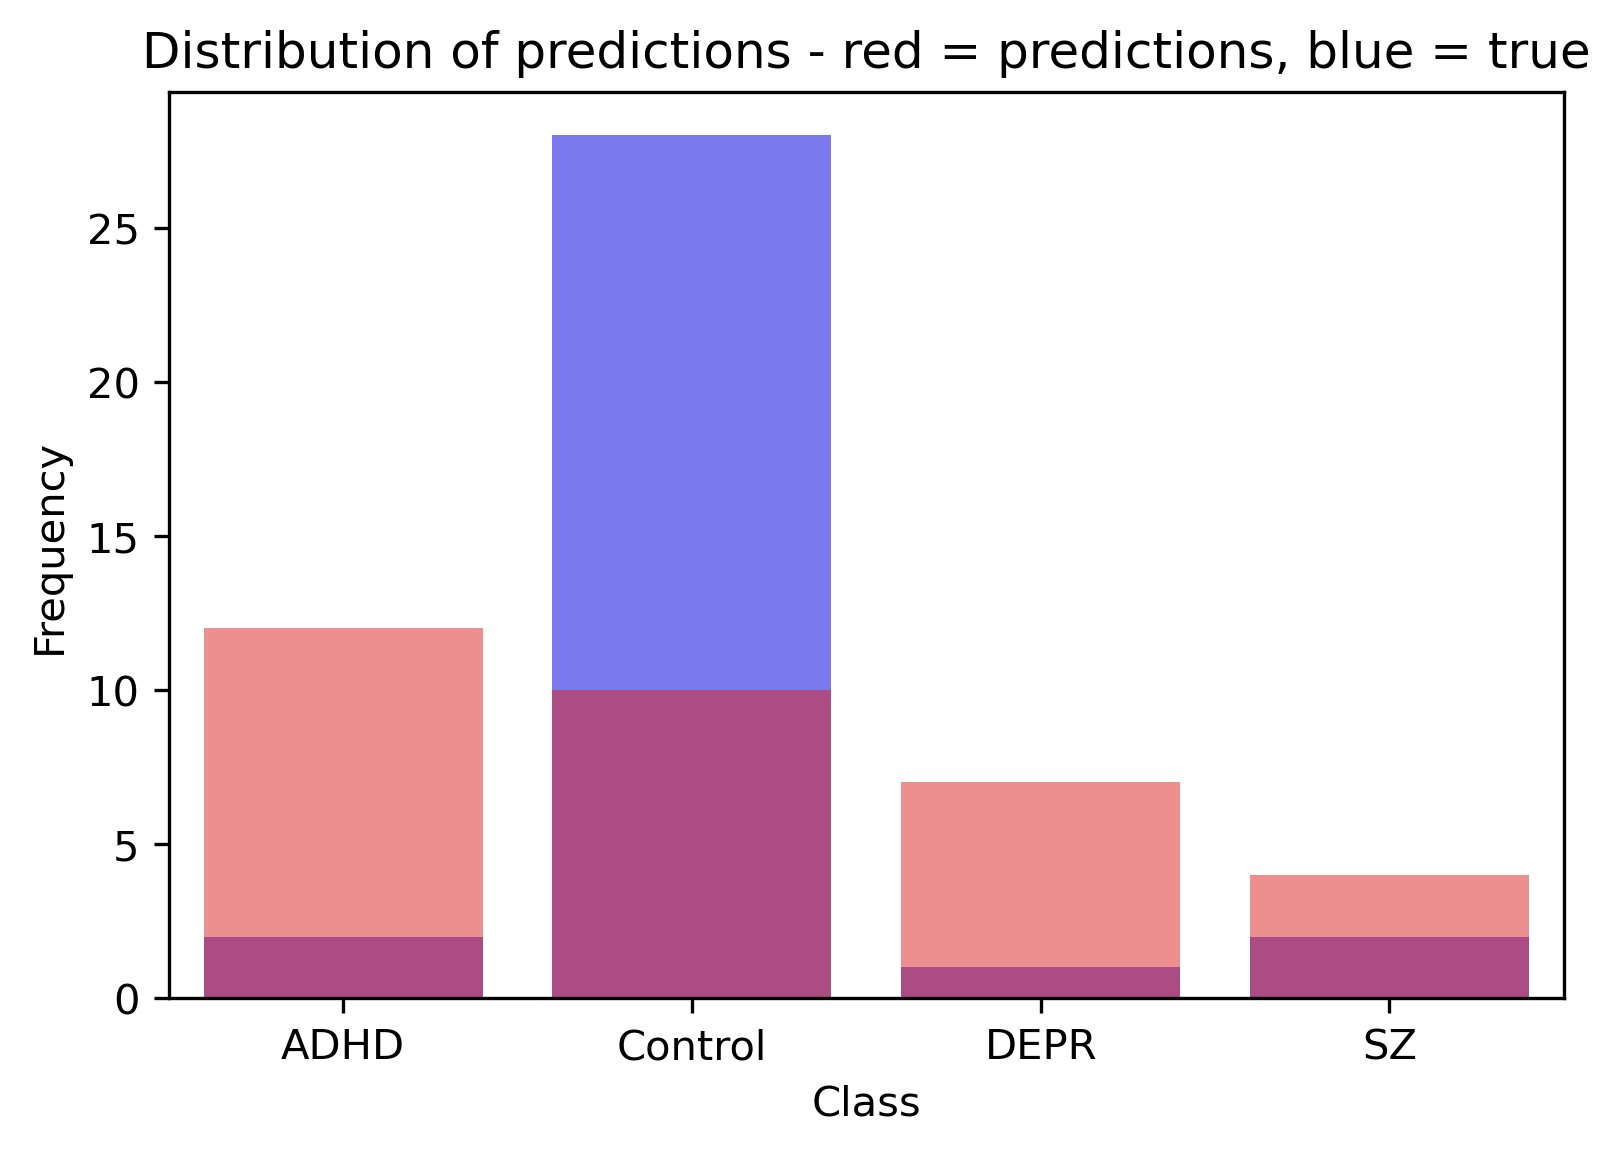

In [29]:
# Plot distributions of predictions
ax = plt.subplots()
unique, counts = np.unique(y_pred, return_counts=True)
ax = sns.barplot(
    x=list(dict(zip(unique, counts)).keys()),
    y=list(dict(zip(unique, counts)).values()),
    color="b",
    alpha=0.6,
)

unique, counts = np.unique(y_test, return_counts=True)
ax = sns.barplot(
    x=list(dict(zip(unique, counts)).keys()),
    y=list(dict(zip(unique, counts)).values()),
    color="r",
    alpha=0.5,
)

ax.set(xlabel="Class", ylabel="Frequency")

ax.set_xticklabels(list(le_name_mapping.keys()))
plt.title("Distribution of predictions - red = predictions, blue = true")
plt.show()

In [30]:
# Print classification report
report = classification_report(
    y_test,
    y_pred,
    labels=list(dict(zip(unique, counts)).keys()),
    target_names=list(le_name_mapping.keys()),
)
print(report)

              precision    recall  f1-score   support

        ADHD       0.00      0.00      0.00        12
     Control       0.29      0.80      0.42        10
        DEPR       1.00      0.14      0.25         7
          SZ       0.50      0.25      0.33         4

    accuracy                           0.30        33
   macro avg       0.45      0.30      0.25        33
weighted avg       0.36      0.30      0.22        33



Text(0.5, 64.16666666666666, 'Pred')

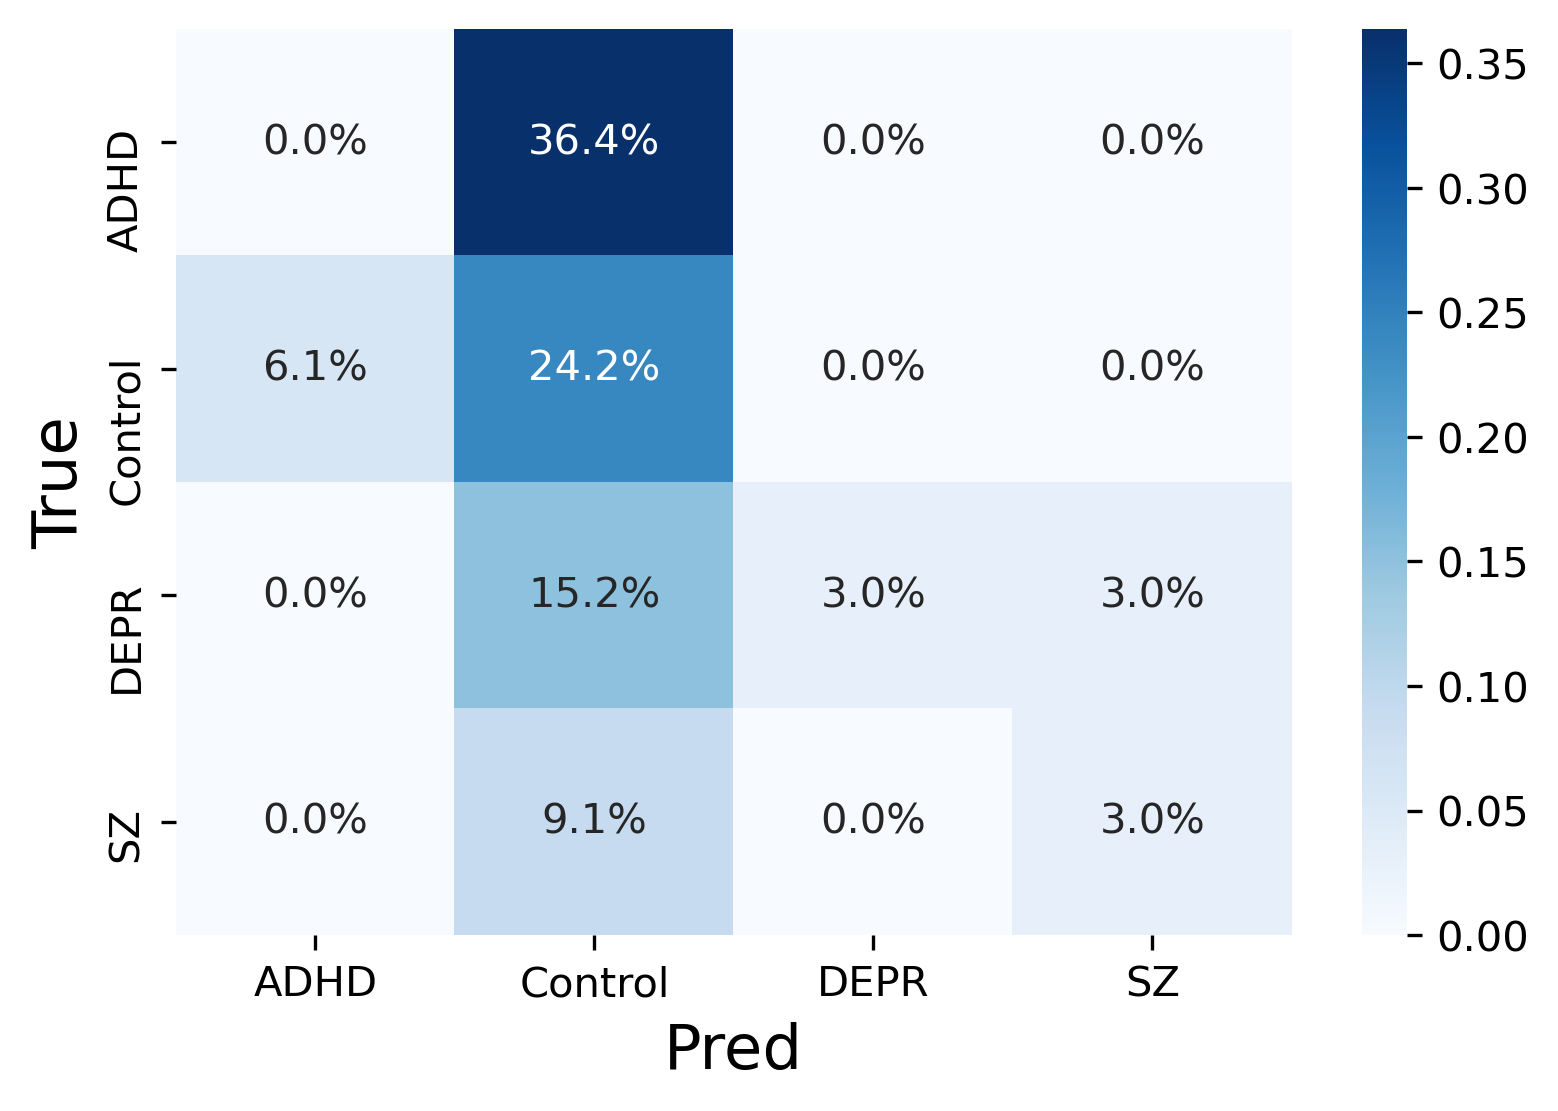

In [35]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=list(le_name_mapping.keys()),
    yticklabels=list(le_name_mapping.keys()),
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

### SHAP-based feature importances

Using 129 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/33 [00:00<?, ?it/s]

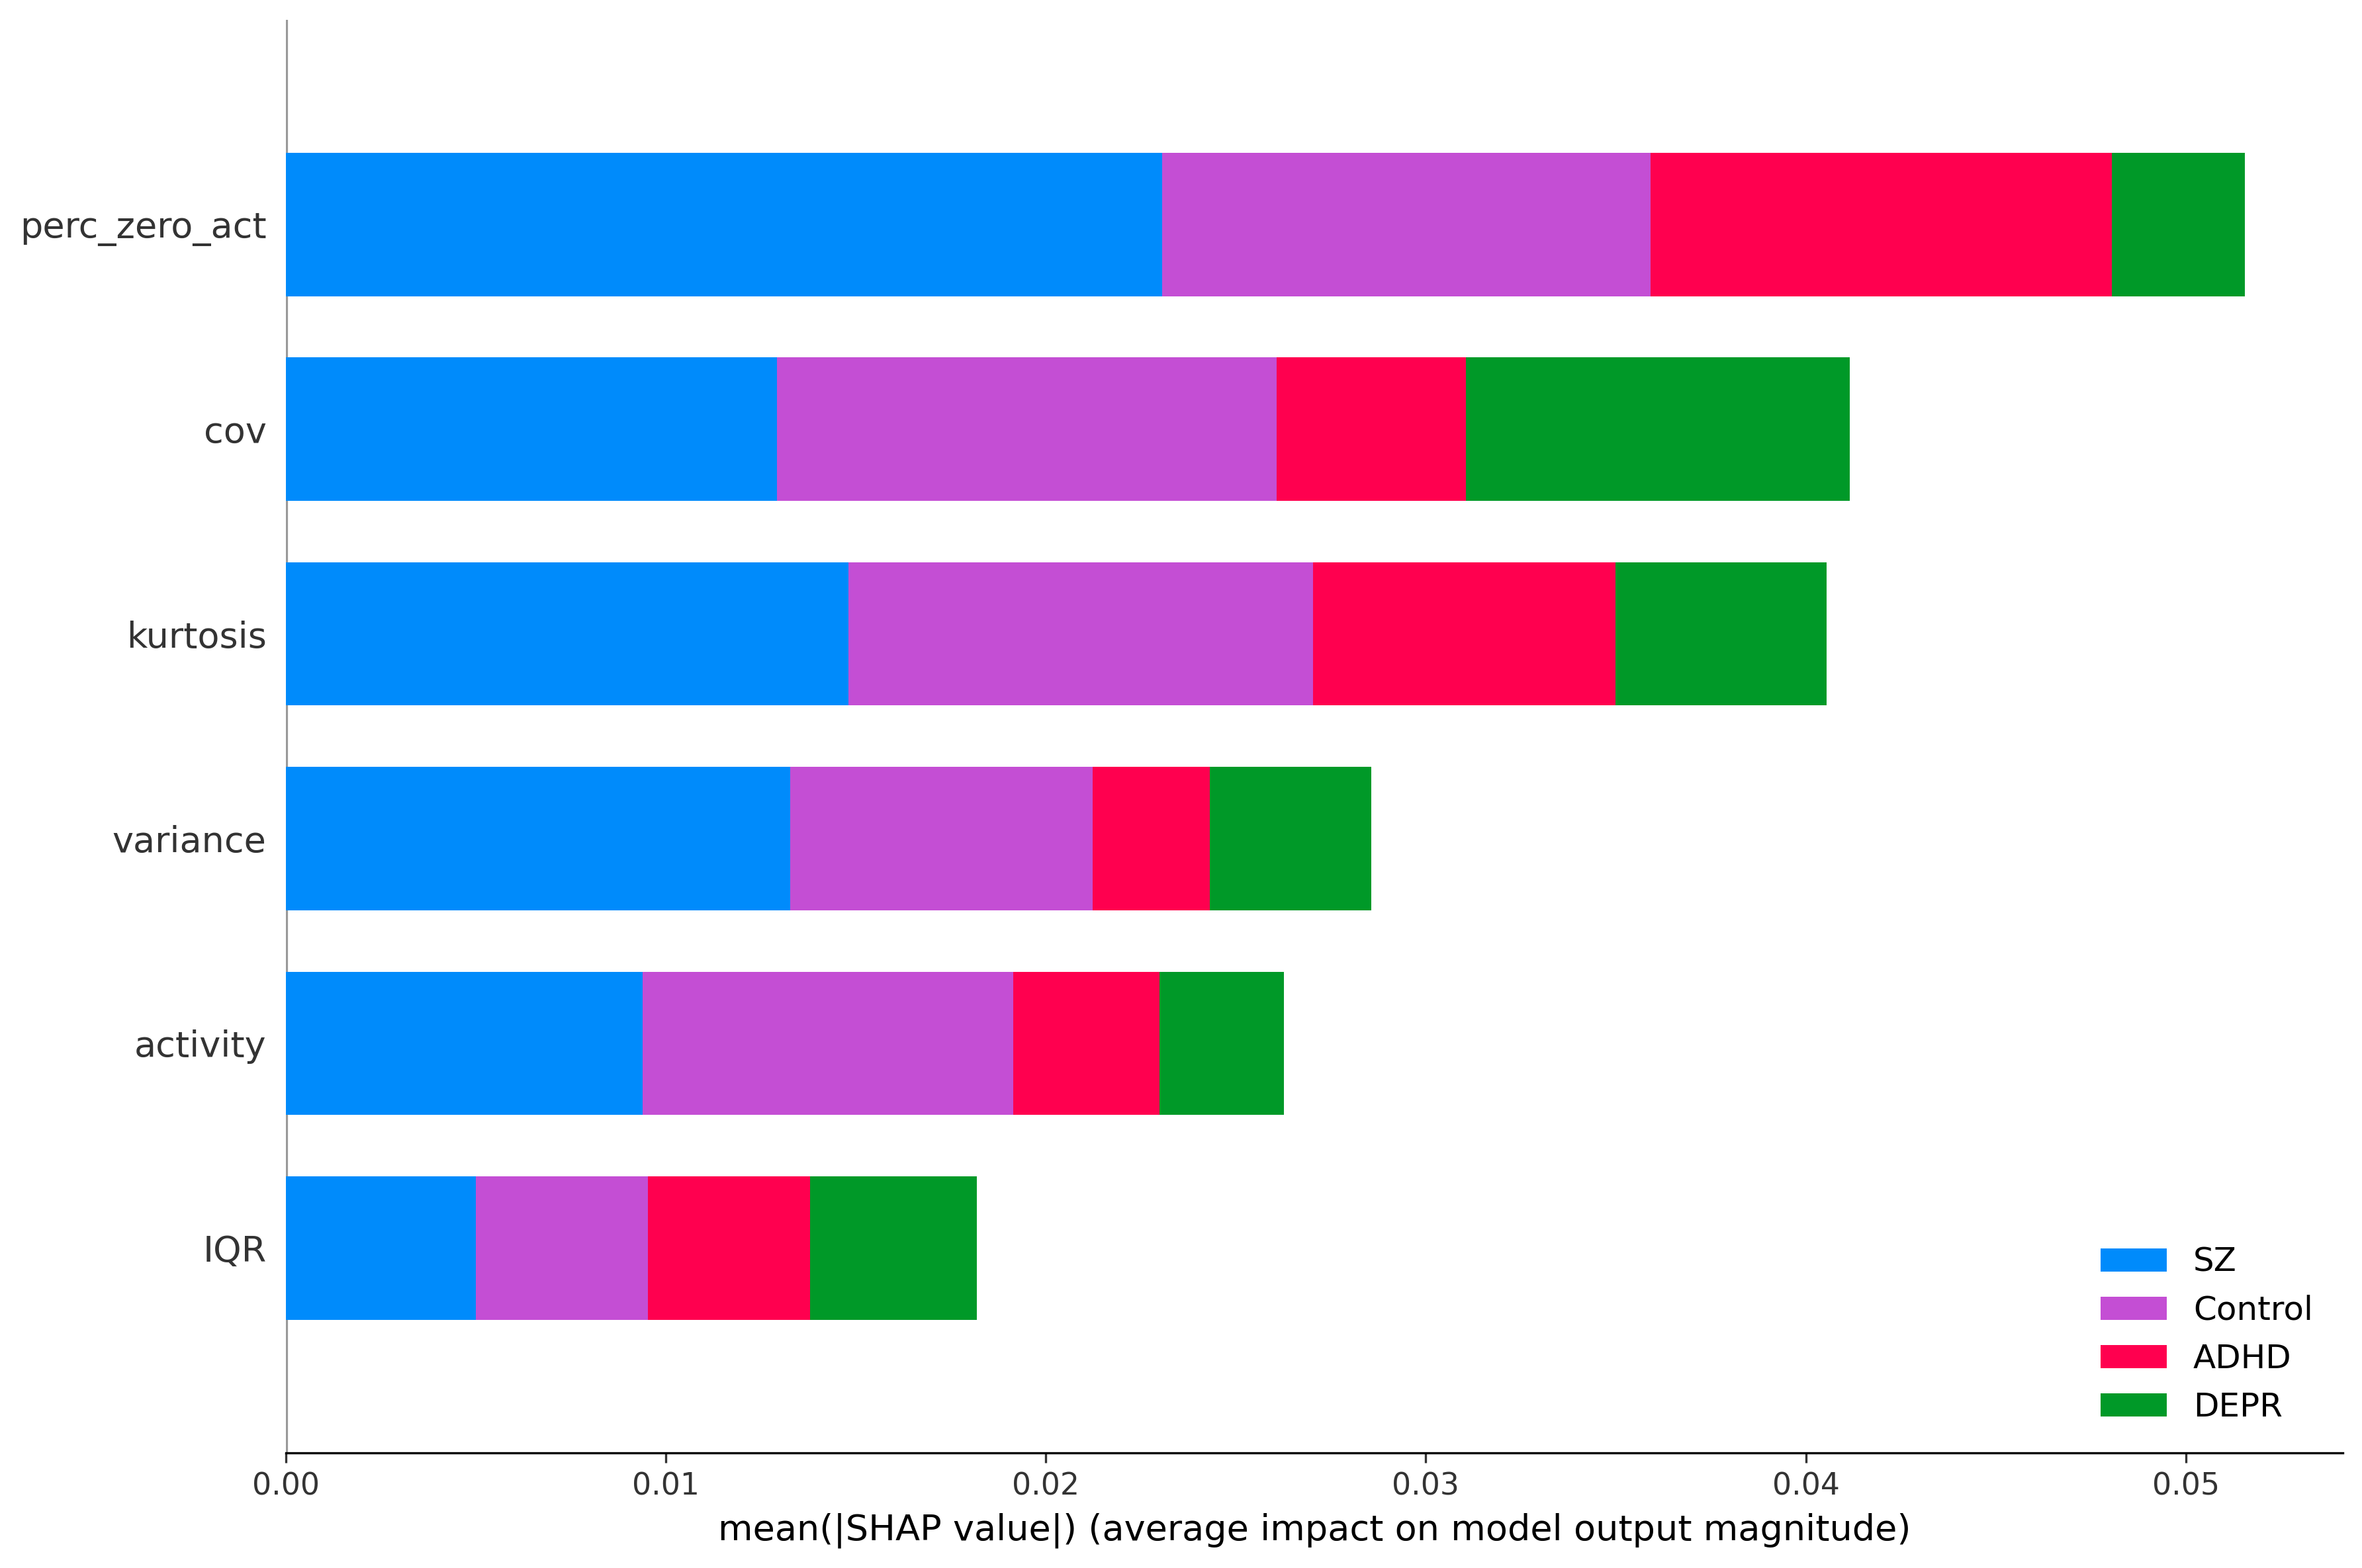

In [36]:
# Get global SHAP values for the model
explainer = shap.KernelExplainer(clf.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    class_names=list(le_name_mapping.keys()),
    plot_size=[12, 8],
)

### Partial dependence plots

Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects. Grey ticks along the y-axis are data points where the feature's value was NaN. <br>
For the sake of space, we only look at the ADHD class and the three features that have the highest correlation.

In [37]:
# Get SHAP values for each subject+feature
shap_values_adhd = pd.DataFrame(shap_values[0], columns=[X_test.columns])
shap_x_test = pd.concat([shap_values_adhd.reset_index(), X_test.reset_index()], axis=1)
shap_x_test.columns = [
    "index_1",
    "activity_shap",
    "variance_shap",
    "kurtosis_shap",
    "cov_shap",
    "IQR_shap",
    "perc_zero_act_shap",
    "index_2",
    "activity_test",
    "variance_test",
    "kurtosis_test",
    "cov_test",
    "IQR_test",
    "perc_zero_act_test",
]
shap_x_test = shap_x_test.drop(["index_1", "index_2"], axis=1)
shap_x_test[0:10]

activity_shap  variance_shap  kurtosis_shap  cov_shap  IQR_shap  \
0       0.002202       0.001301      -0.004681  0.005567  0.002423   
1       0.003365      -0.000374       0.003633  0.002165  0.000525   
2       0.003818       0.000580       0.003956  0.002757  0.000929   
3       0.003633      -0.000757       0.004886  0.003029  0.001342   
4       0.004260       0.000023       0.000848  0.001541  0.005871   
5       0.000184      -0.001890       0.005751  0.001360 -0.000388   
6       0.005358       0.000486       0.006256  0.003685  0.002037   
7       0.003746      -0.000138      -0.002006  0.004340  0.002488   
8       0.004923       0.005974       0.028754  0.001019  0.019390   
9       0.003313       0.000277       0.003430  0.002734  0.000462   

   perc_zero_act_shap  activity_test  variance_test  kurtosis_test  cov_test  \
0           -0.000860      -0.522487      -0.476719       0.698664  0.356262   
1            0.005592       0.345266       0.132238      -0.495540 -0.517538   
2            0.002574       0.495959       0.583970      -0.479452 -0.279355   
3            0.008080       0.317130      -0.256718      -0.703309 -0.950217   
4            0.006463       1.182827       0.760493      -0.099103 -1.001068   
5            0.004261      -0.606065      -0.833835      -0.466565 -0.263636   
6            0.010843       0.843237       0.388318      -0.755853 -0.930229   
7            0.004465       0.061947       0.189453       0.371028  0.050024   
8            0.010721       1.757883       1.014631      -1.097677 -1.353186   
9            0.003011       0.327970       0.360998      -0.415346 -0.235512   

   IQR_test  perc_zero_act_test  
0 -0.456125            0.597334  
1  0.336645           -0.323814  
2  0.434216            0.123340  
3  0.470805           -0.538989  
4  1.355048           -0.357501  
5 -0.462223            0.287777  
6  0.653752           -0.925479  
7  0.117108           -0.342416  
8  2.129522           -0.447013  
9  0.245171            0.075107

In [38]:
# Get correlations between magnitudes of feature values and SHAP importance attribution of that feature
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["activity"])), X_test["activity"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["variance"])), X_test["variance"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["kurtosis"])), X_test["kurtosis"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["cov"])), X_test["cov"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["IQR"])), X_test["IQR"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["perc_zero_act"])), X_test["perc_zero_act"])[0])

0.5038667796693047
0.6265737317888402
-0.798757674494829
-0.4127286540997961
0.7258393001911069
-0.8141365346626437


#### SHAP - % zero activity, ADHD

Text(0.5, 1.0, 'ADHD')

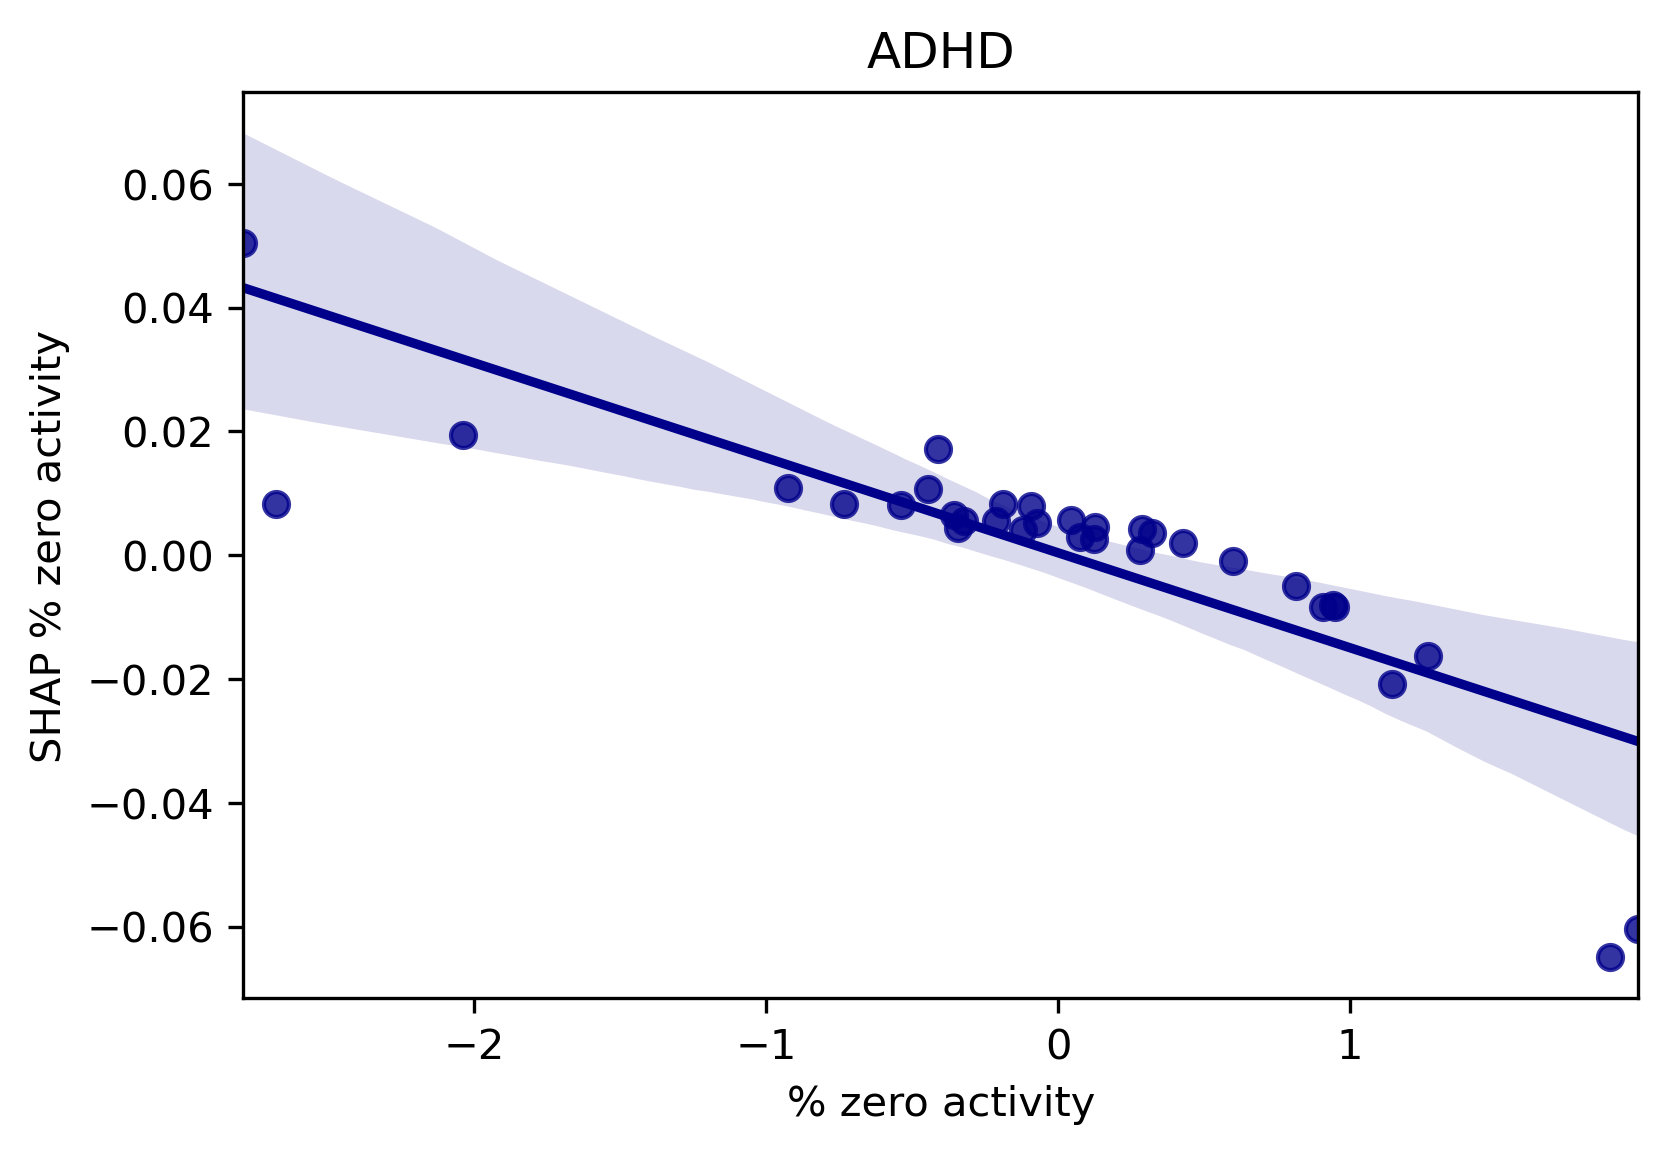

In [40]:
ax = sns.regplot(
    x=shap_x_test["perc_zero_act_test"],
    y=shap_x_test["perc_zero_act_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="% zero activity", ylabel="SHAP % zero activity")
plt.title("ADHD")

#### SHAP - IQR, ADHD

Text(0.5, 1.0, 'ADHD')

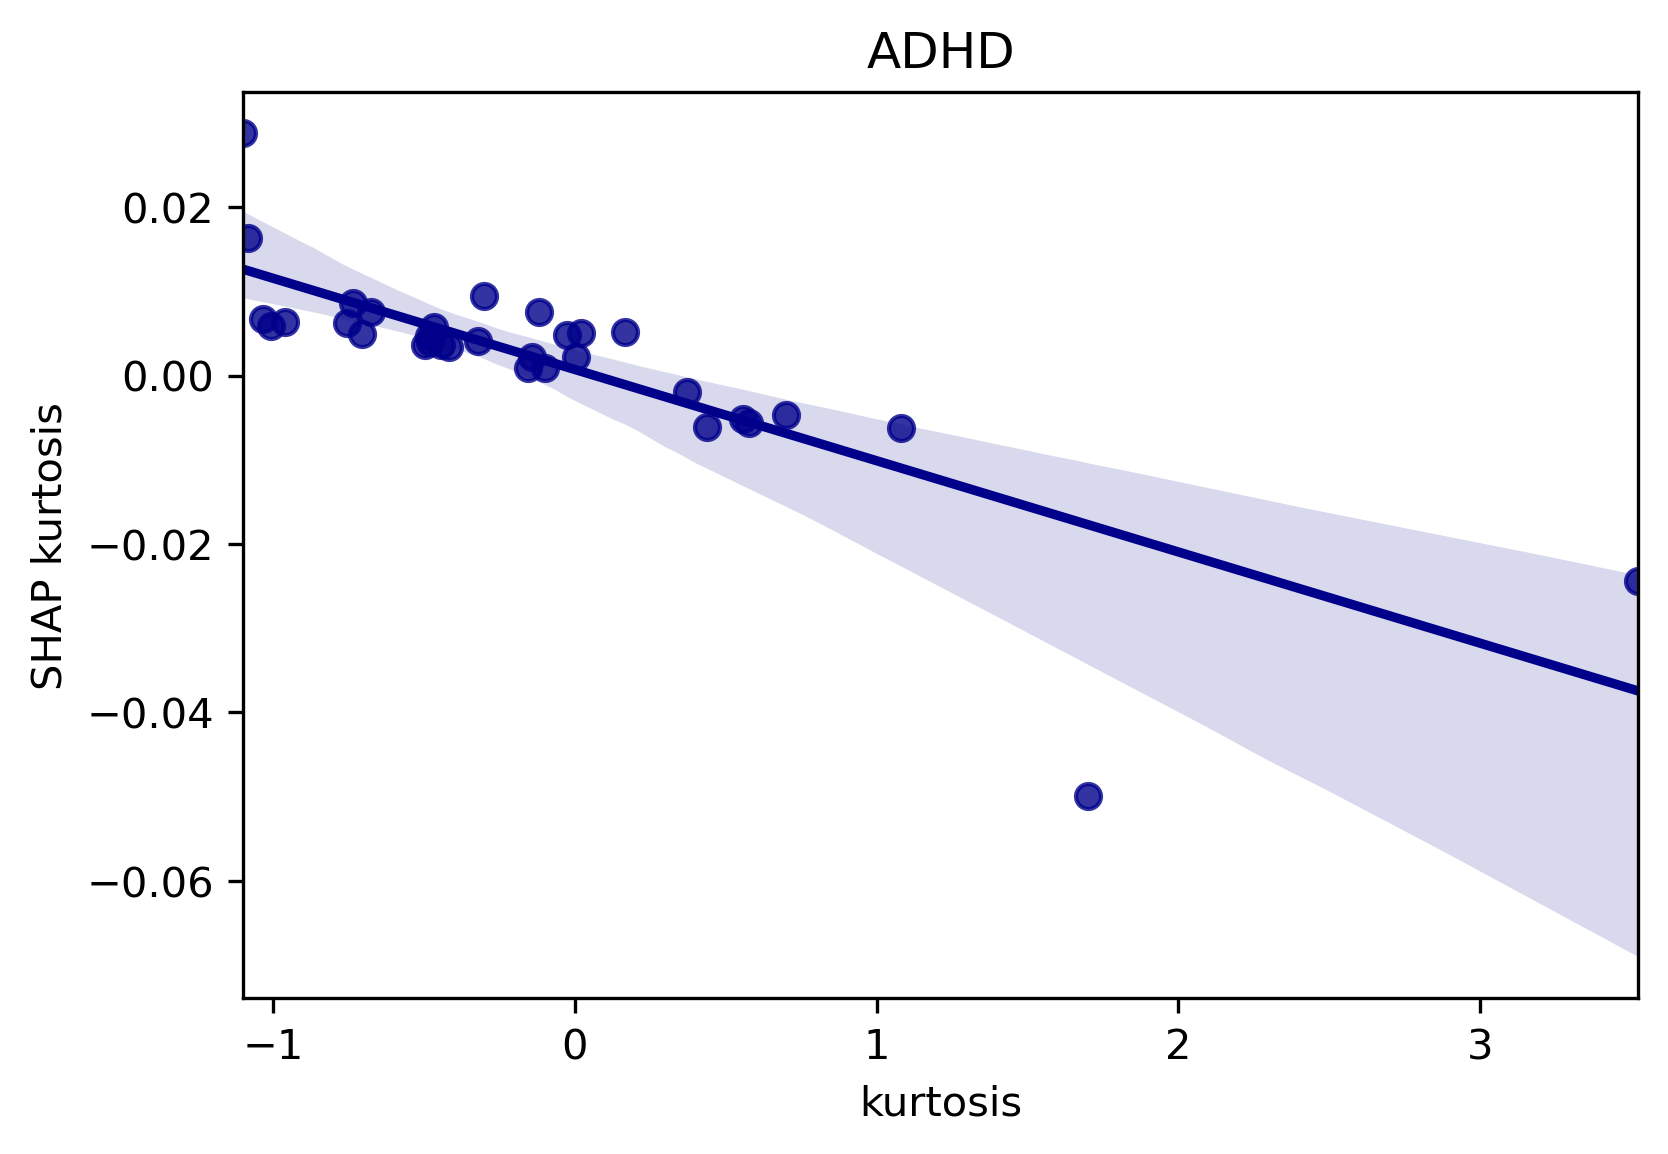

In [39]:
ax = sns.regplot(
    x=shap_x_test["kurtosis_test"],
    y=shap_x_test["kurtosis_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="kurtosis", ylabel="SHAP kurtosis")
plt.title("ADHD")

#### SHAP - Coefficient of variation, ADHD

Text(0.5, 1.0, 'ADHD')

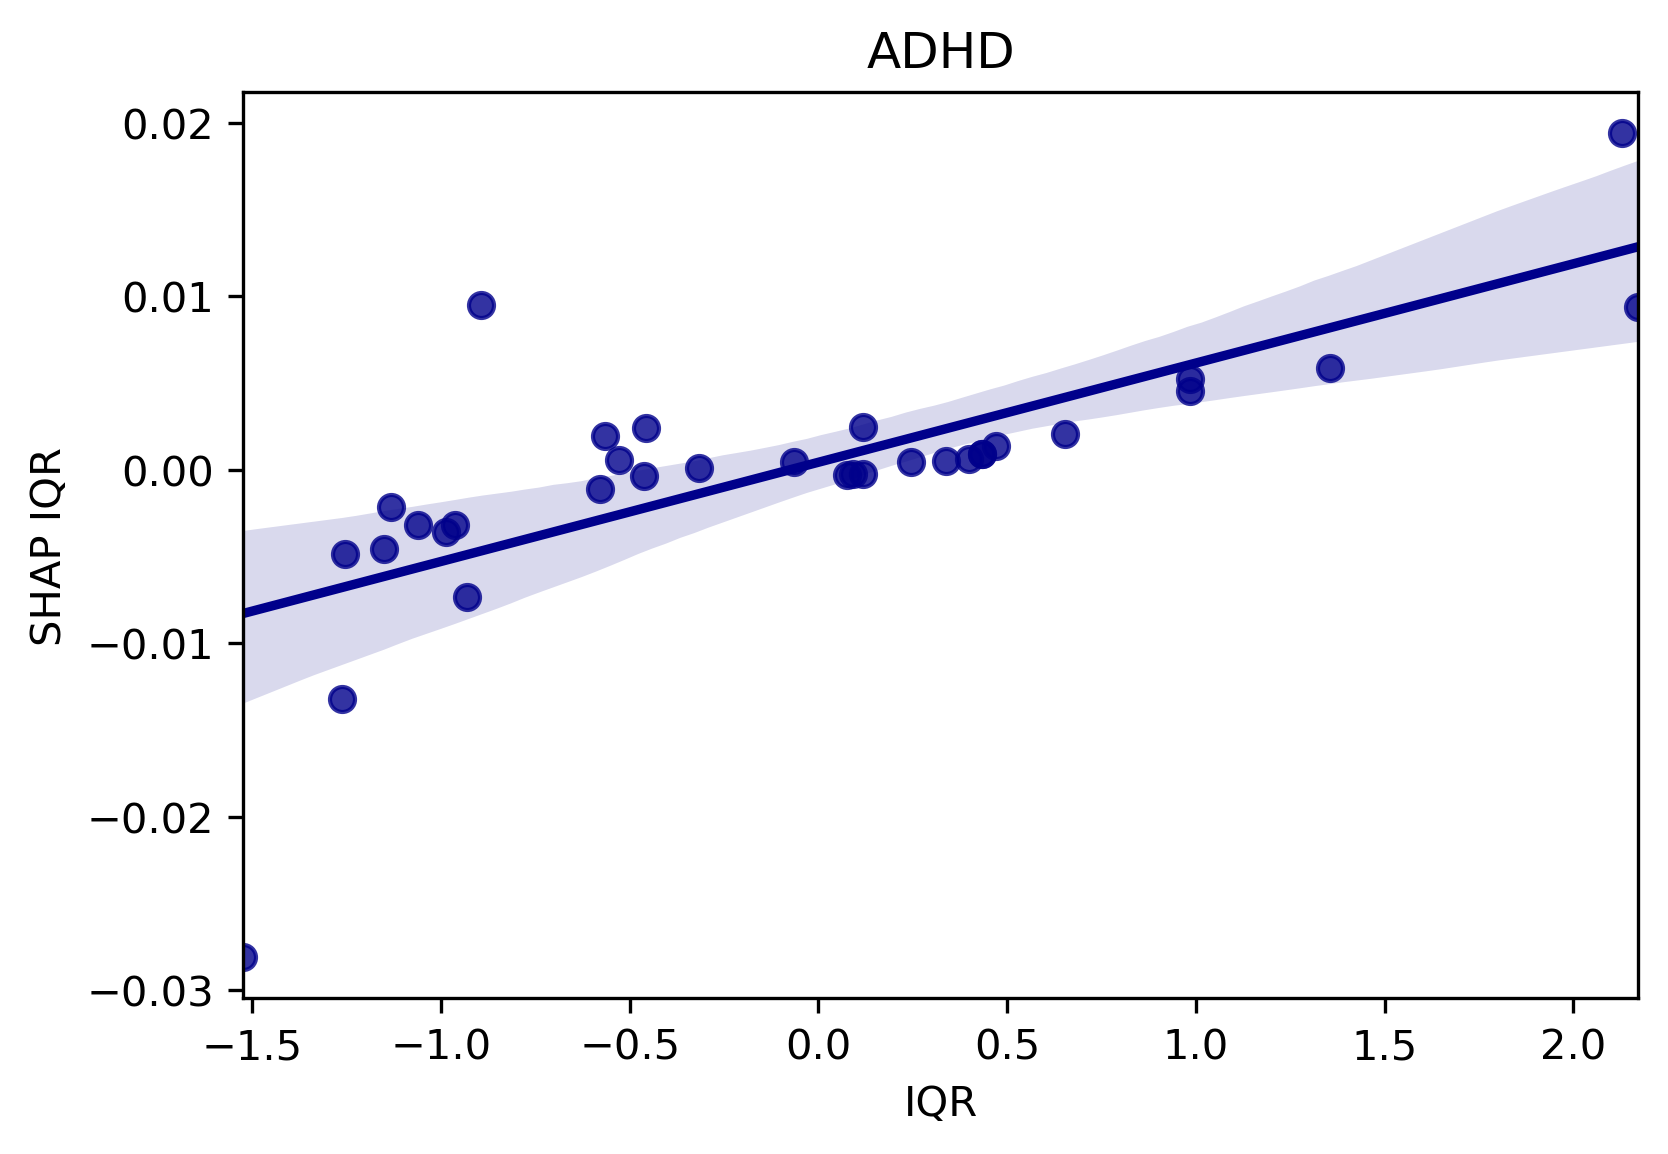

In [42]:
ax = sns.regplot(
    x=shap_x_test["IQR_test"],
    y=shap_x_test["IQR_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="IQR", ylabel="SHAP IQR")
plt.title("ADHD")

## Optimization and investigation of *RF* (best performing model on upsampled data)

### Find optimal hyperparameters

In [43]:
# Create dataset using same random state as before
X_train, X_test, y_train, y_test = manual_feature_splitter(
    features, labels, test_ratio=0.2, upsample=True, random_state=42
)

(248, 6) (248,) (33, 6) (33,)


In [51]:
def objective_RF(trial):
    """Defines the objective function to evalute performance of RF model."""
    # Define features to optimize
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("rf_max_depth", 2, 50, log=True)
    max_features = trial.suggest_float("max_features", 0.1, 1)
    min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 4])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    n_estimators = trial.suggest_int("n_estimators", 80, 1200, 20)

    # Create model
    rf_model = RandomForestClassifier(
        criterion=criterion,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        n_jobs=12,
    )

    # Compute and return cross validation score
    score = cross_val_score(
        rf_model, X_train, y_train.values.ravel(), cv=5, scoring="f1_weighted"
    ).mean()
    return score

In [52]:
# Optimize hyperparameters for the SVC model
study = optuna.create_study(sampler=TPESampler(), direction="maximize")
study.optimize(objective_RF, n_trials=200)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-12-06 19:33:48,578] A new study created in memory with name: no-name-83898150-c27b-4c1c-9a92-7047064a095b
[I 2022-12-06 19:33:49,432] Trial 0 finished with value: 0.49344761933143033 and parameters: {'criterion': 'gini', 'rf_max_depth': 2, 'max_features': 0.21903678817012234, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 280}. Best is trial 0 with value: 0.49344761933143033.
[I 2022-12-06 19:33:50,471] Trial 1 finished with value: 0.6323080138988235 and parameters: {'criterion': 'entropy', 'rf_max_depth': 18, 'max_features': 0.7978180642580301, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 240}. Best is trial 1 with value: 0.6323080138988235.
[I 2022-12-06 19:33:53,516] Trial 2 finished with value: 0.5670001589900904 and parameters: {'criterion': 'entropy', 'rf_max_depth': 3, 'max_features': 0.9294335042499157, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1100}. Best is trial 1 with value: 0.6323080138988235.
[I 2022-12-06 1

Best Score:  0.6565014634251531
Best Params: 
  criterion: gini
  rf_max_depth: 27
  max_features: 0.6964365161806665
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 620


In [53]:
# Visualize the importance of parameters for model performance
optuna.visualization.plot_param_importances(study)

In [55]:
# create classifier with best parameters
clf = RandomForestClassifier(
    criterion="gini",
    max_depth=27,
    max_features=0.6964365161806665,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=620,
    n_jobs=12,
)
clf.fit(X_train, y_train)

# generate predictions on test set
y_pred = pd.DataFrame(np.round(clf.predict(X_test), 0), columns=["y_pred"])
# evaluate model
accuracy = round(accuracy_score(y_test, y_pred), 4)
print("Accuracy: " + str(accuracy))
precision = round(precision_score(y_test, y_pred, average="weighted"), 4)
print("Precision: " + str(precision))

F1 = round(f1_score(y_test, y_pred, average="weighted"), 4)
print("F1 Score: " + str(F1))

cv_scores = np.round(np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy")), 4)
print("Cross val scores: " + str(cv_scores))

Accuracy: 0.4242
Precision: 0.4848
F1 Score: 0.4241
Cross val scores: 0.6697


### What type of predictions did it make?

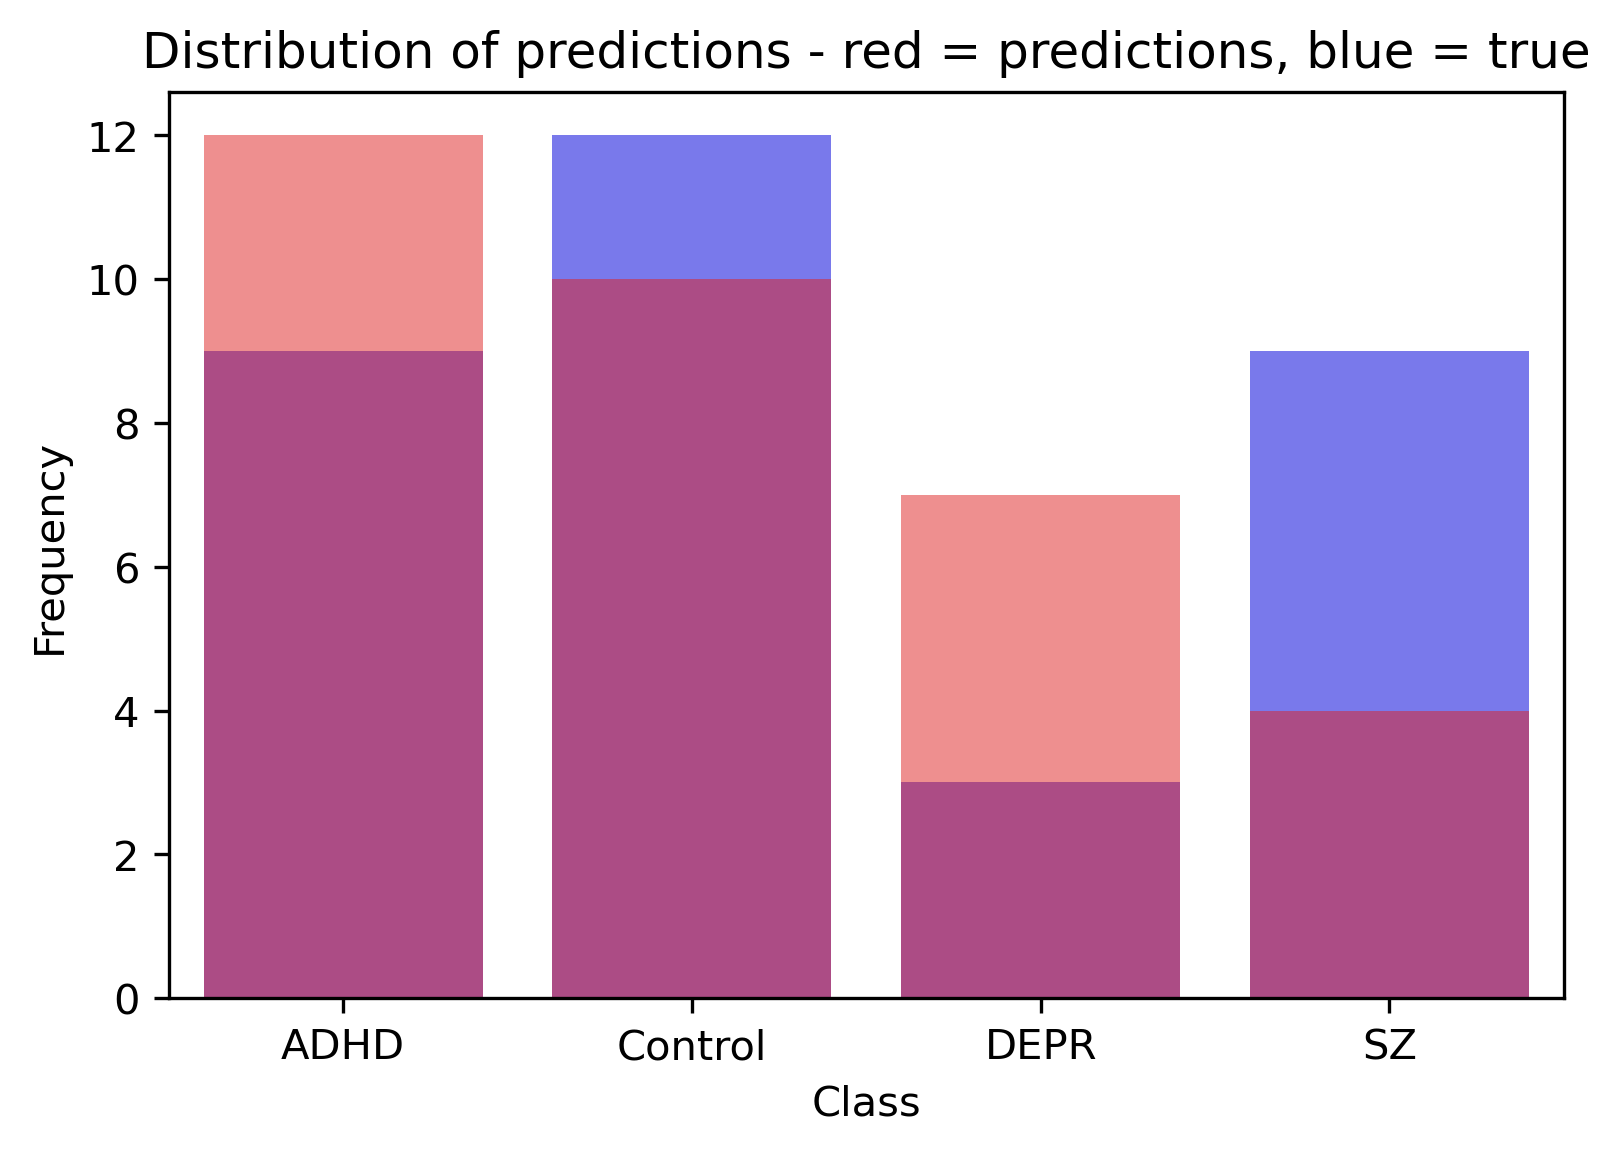

In [56]:
# Plot distributions of predictions
ax = plt.subplots()
unique, counts = np.unique(y_pred, return_counts=True)
ax = sns.barplot(
    x=list(dict(zip(unique, counts)).keys()),
    y=list(dict(zip(unique, counts)).values()),
    color="b",
    alpha=0.6,
)

unique, counts = np.unique(y_test, return_counts=True)
ax = sns.barplot(
    x=list(dict(zip(unique, counts)).keys()),
    y=list(dict(zip(unique, counts)).values()),
    color="r",
    alpha=0.5,
)

ax.set(xlabel="Class", ylabel="Frequency")

ax.set_xticklabels(list(le_name_mapping.keys()))
plt.title("Distribution of predictions - red = predictions, blue = true")
plt.show()

In [57]:
# Print classification report
report = classification_report(
    y_test,
    y_pred,
    labels=list(dict(zip(unique, counts)).keys()),
    target_names=list(le_name_mapping.keys()),
)
print(report)

              precision    recall  f1-score   support

        ADHD       0.56      0.42      0.48        12
     Control       0.33      0.40      0.36        10
        DEPR       0.67      0.29      0.40         7
          SZ       0.33      0.75      0.46         4

    accuracy                           0.42        33
   macro avg       0.47      0.46      0.43        33
weighted avg       0.48      0.42      0.42        33



Text(0.5, 64.16666666666666, 'Pred')

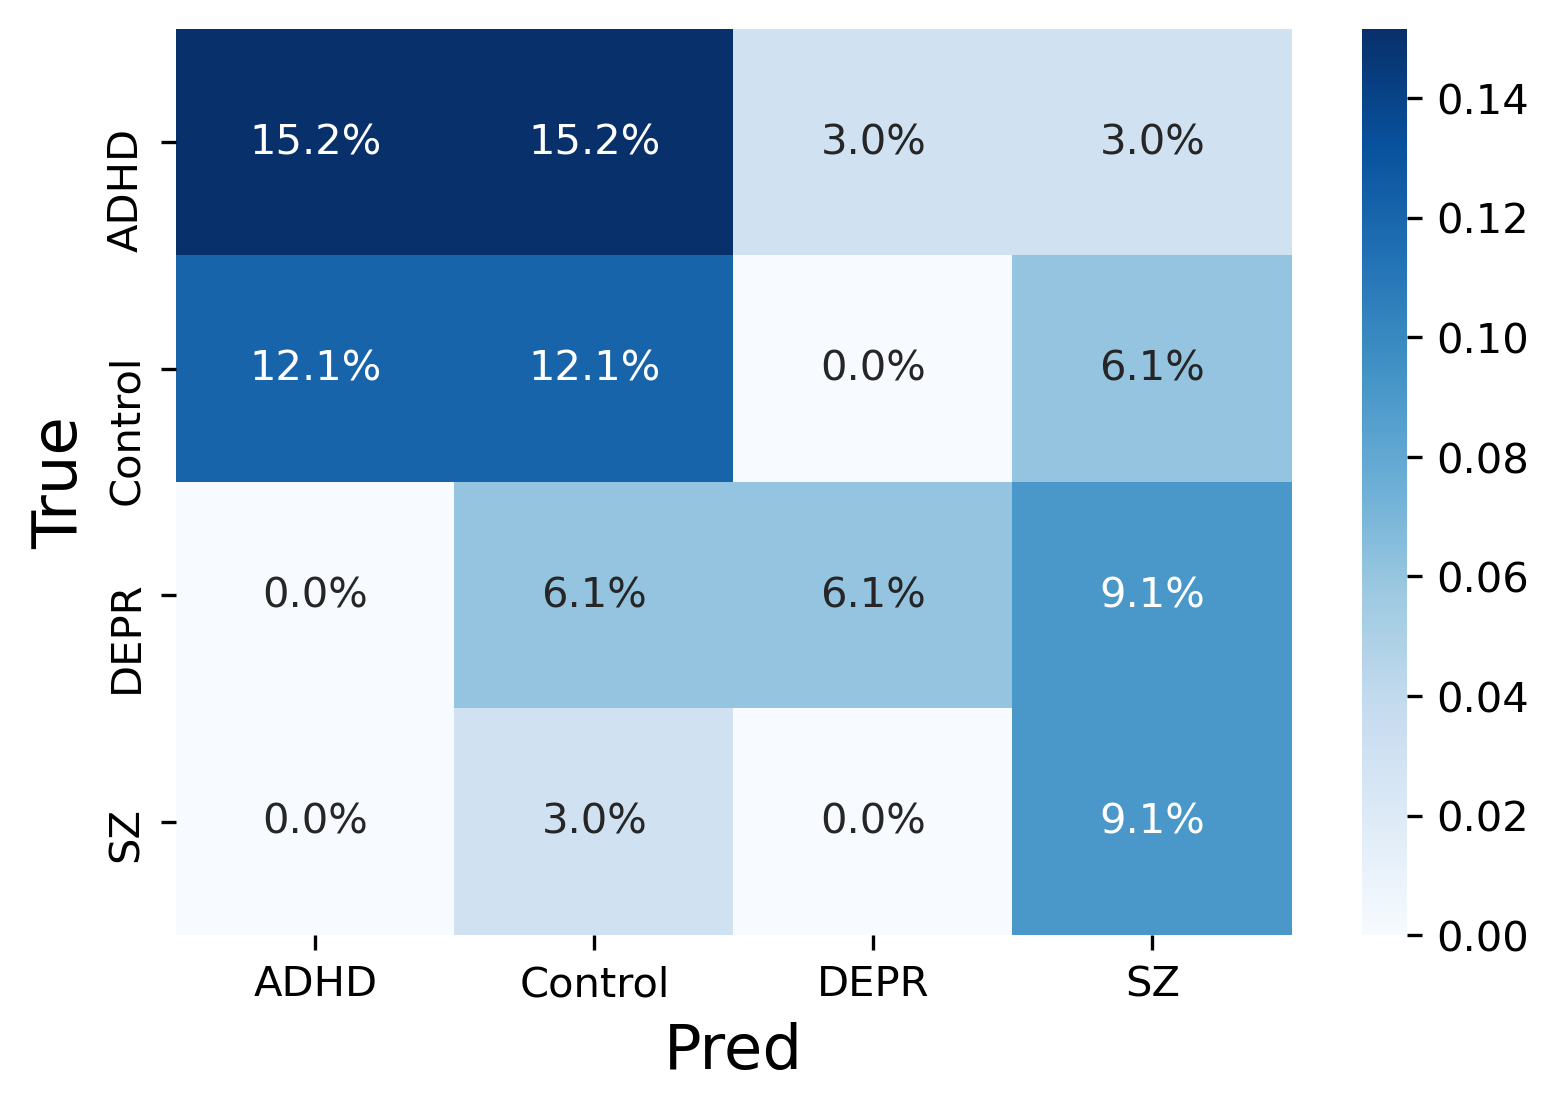

In [58]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm / np.sum(cm),
    annot=True,
    fmt=".1%",
    cmap="Blues",
    xticklabels=list(le_name_mapping.keys()),
    yticklabels=list(le_name_mapping.keys()),
)
plt.ylabel("True", fontsize=15)  # x-axis label with fontsize 15
plt.xlabel("Pred", fontsize=15)  # y-axis label with fontsize 15

### Impurity-based feature importances

Text(0.5, 0, 'Random Forest Feature Importance')

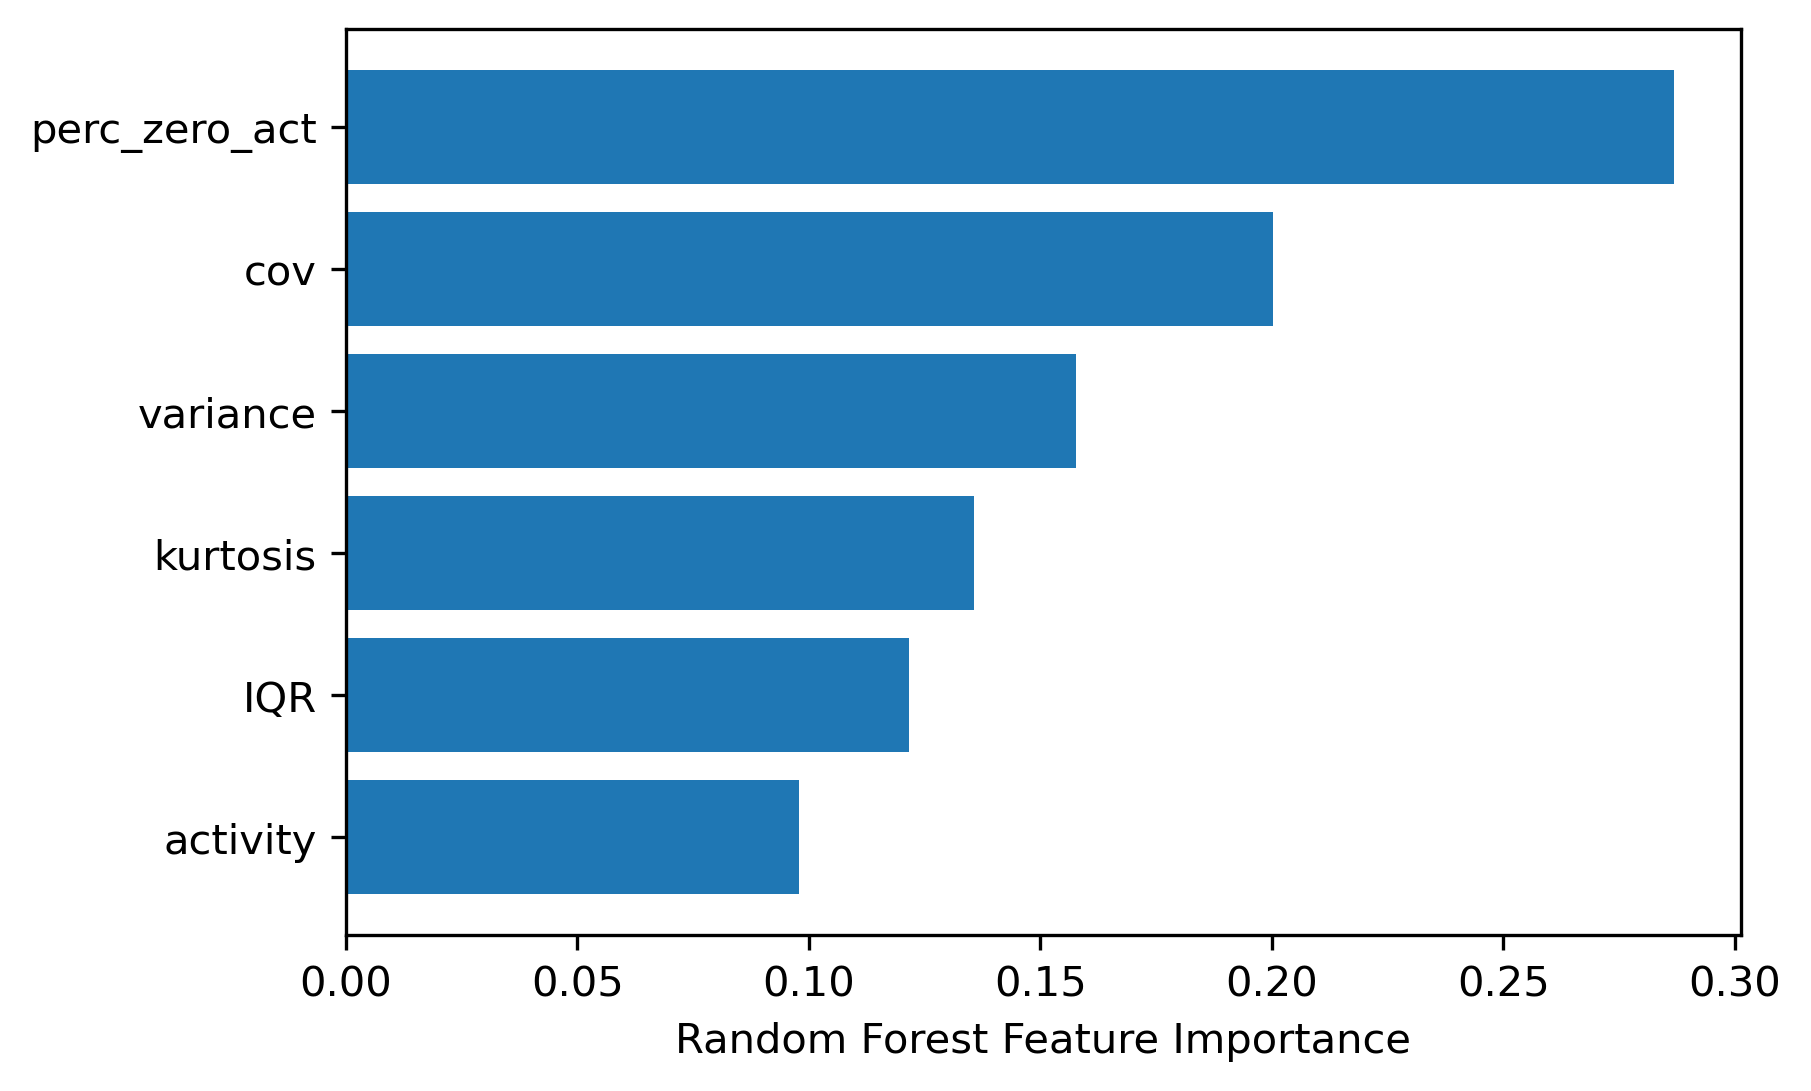

In [59]:
# Compute impurity-based global feature importance attributions
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_test.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### SHAP-based feature importances

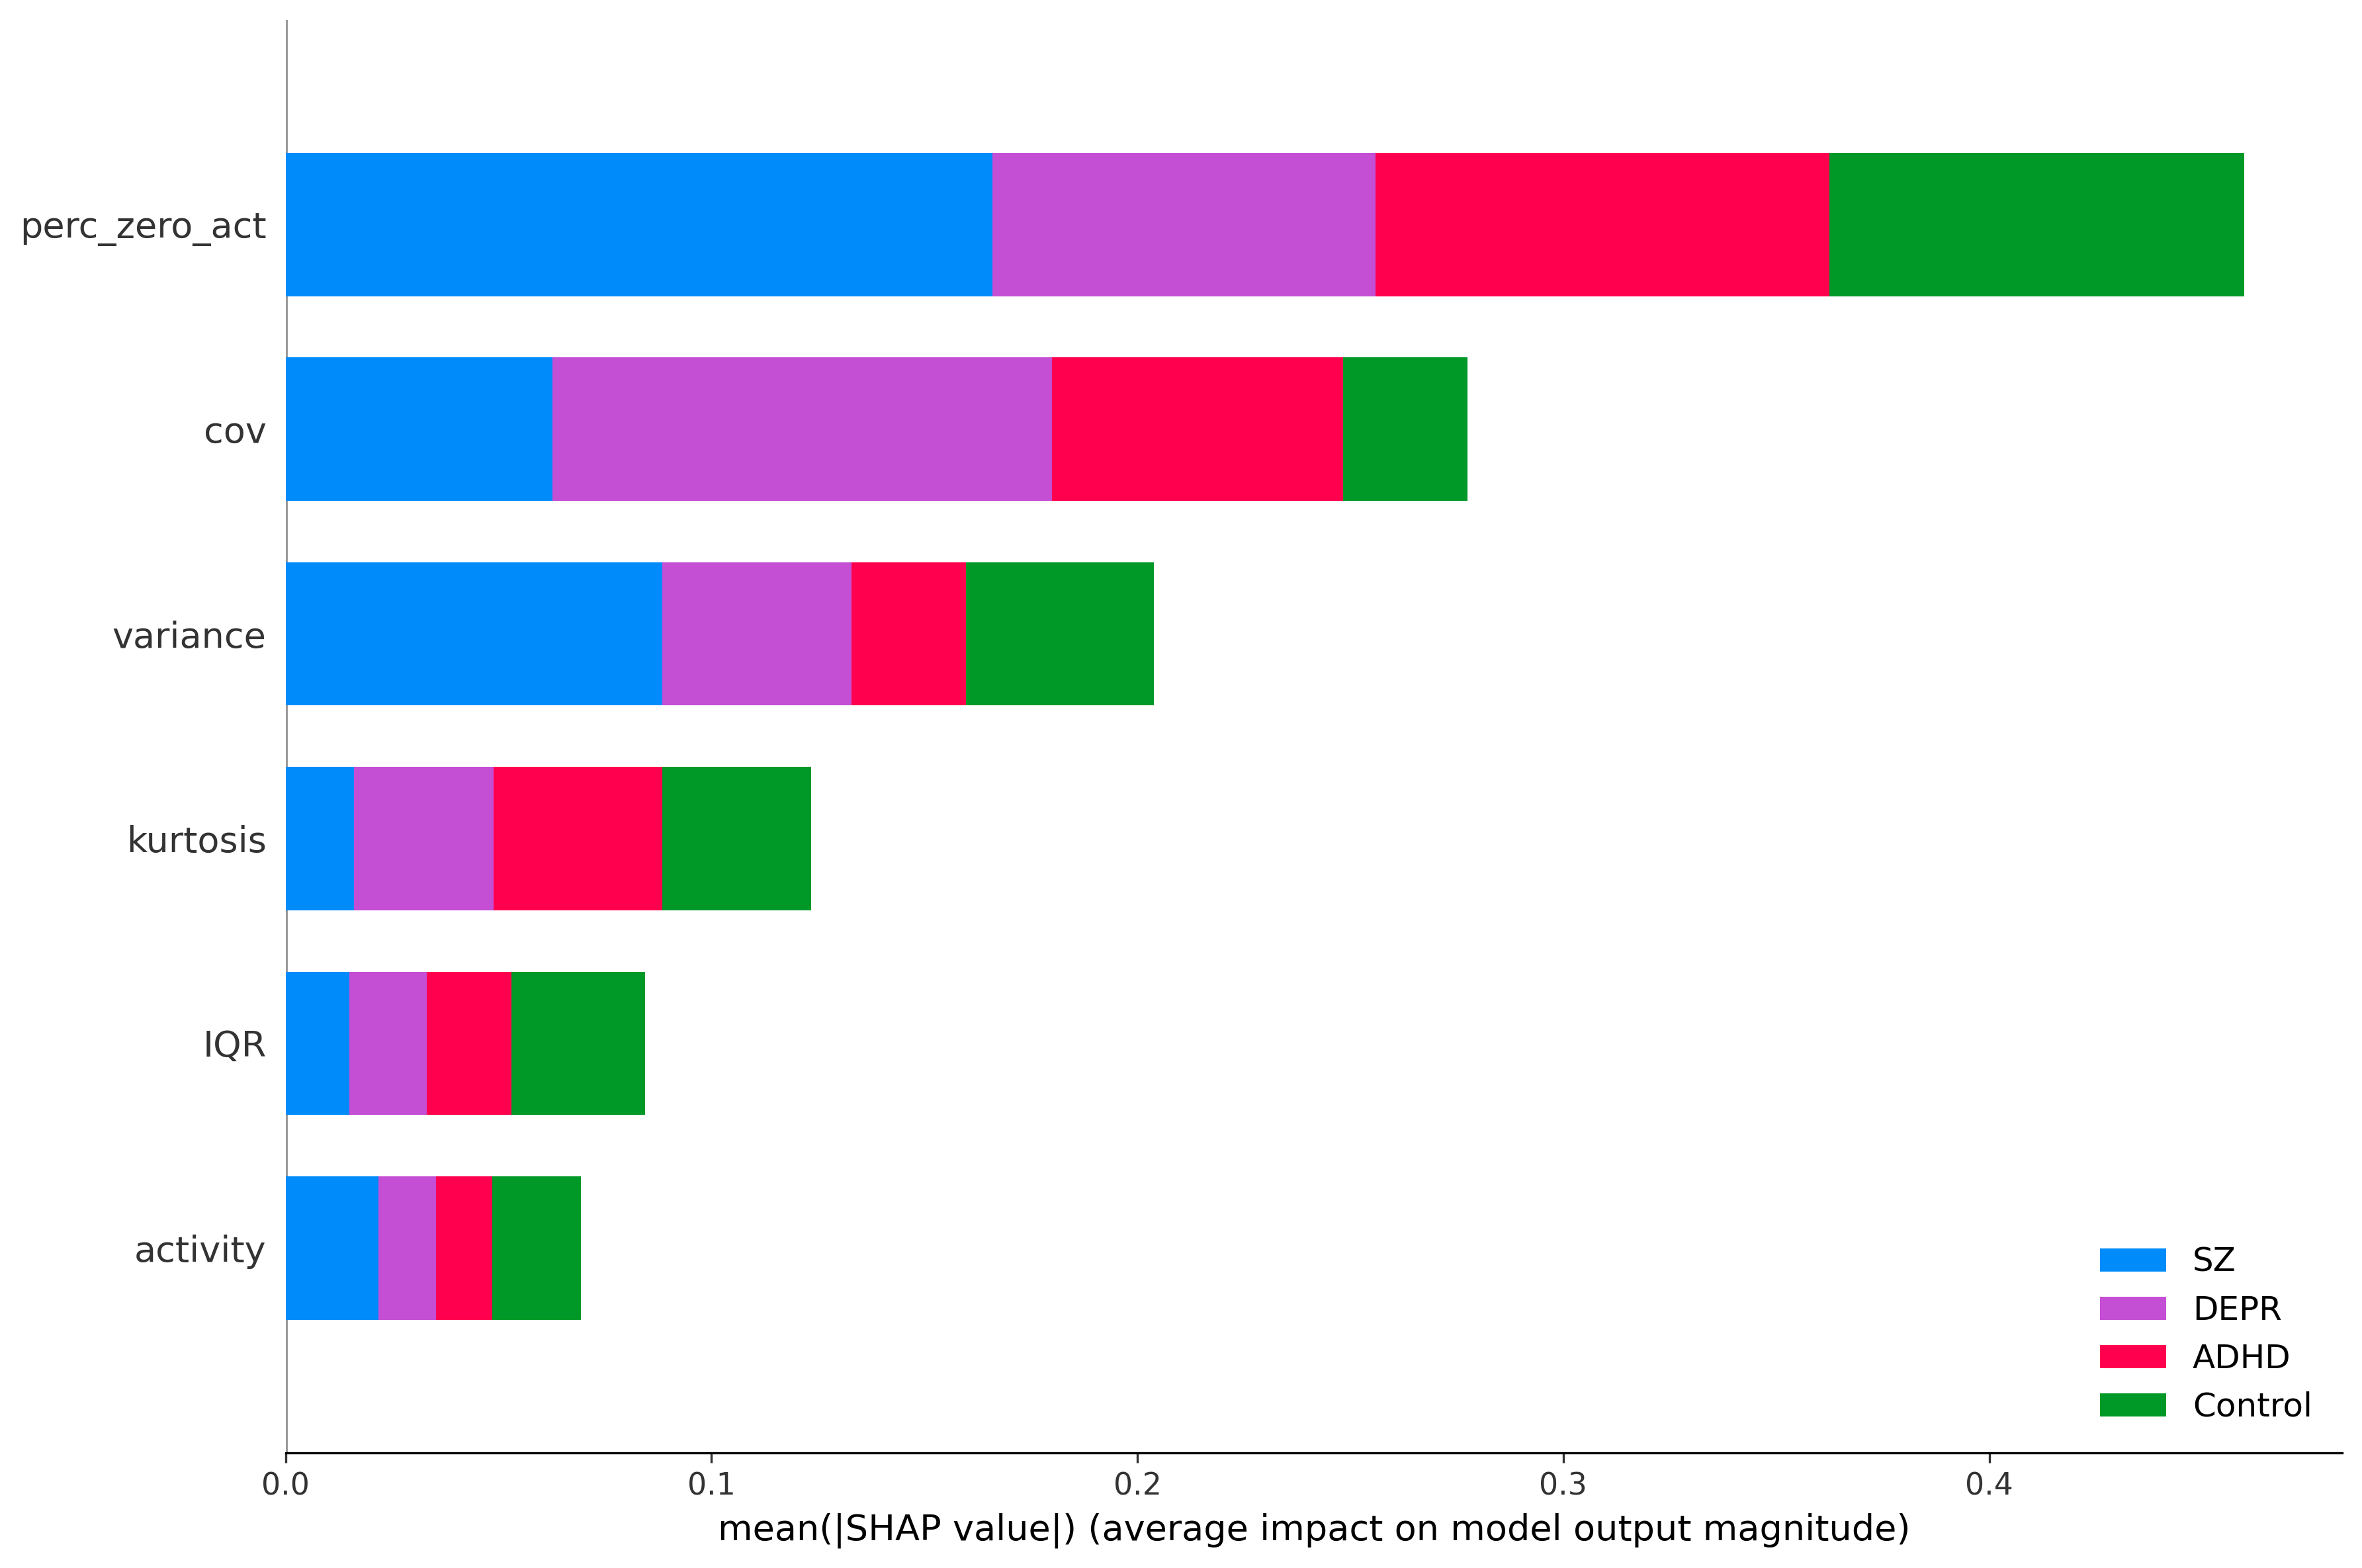

In [60]:
# Get global SHAP values for the model
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    class_names=list(le_name_mapping.keys()),
    plot_size=[12, 8],
)

### Partial dependence plots

In [61]:
# Get SHAP values for each subject+feature
shap_values_adhd = pd.DataFrame(shap_values[0], columns=[X_test.columns])
shap_x_test = pd.concat([shap_values_adhd.reset_index(), X_test.reset_index()], axis=1)
shap_x_test.columns = [
    "index_1",
    "activity_shap",
    "variance_shap",
    "kurtosis_shap",
    "cov_shap",
    "IQR_shap",
    "perc_zero_act_shap",
    "index_2",
    "activity_test",
    "variance_test",
    "kurtosis_test",
    "cov_test",
    "IQR_test",
    "perc_zero_act_test",
]
shap_x_test = shap_x_test.drop(["index_1", "index_2"], axis=1)
shap_x_test[0:10]

activity_shap  variance_shap  kurtosis_shap  cov_shap  IQR_shap  \
0       0.003572      -0.018524      -0.049007 -0.080718  0.021343   
1       0.008861      -0.017973       0.034354  0.152774 -0.019657   
2      -0.028642      -0.024221       0.017057  0.114614 -0.000941   
3       0.008546      -0.025436       0.052828  0.021754 -0.002371   
4       0.026460      -0.017499      -0.048240  0.055063 -0.006704   
5       0.010291      -0.028570       0.018557  0.061928  0.029725   
6      -0.034229      -0.029067       0.097144  0.013043 -0.007659   
7      -0.001279      -0.030274      -0.061583 -0.110616  0.003067   
8      -0.001638       0.014824      -0.070363  0.044324 -0.115578   
9       0.000631      -0.039020       0.019486  0.091731 -0.030904   

   perc_zero_act_shap  activity_test  variance_test  kurtosis_test  cov_test  \
0           -0.062301      -0.522487      -0.476719       0.698664  0.356262   
1            0.281813       0.345266       0.132238      -0.495540 -0.517538   
2            0.059080       0.495959       0.583970      -0.479452 -0.279355   
3            0.157433       0.317130      -0.256718      -0.703309 -0.950217   
4            0.219802       1.182827       0.760493      -0.099103 -1.001068   
5           -0.024339      -0.606065      -0.833835      -0.466565 -0.263636   
6            0.047715       0.843237       0.388318      -0.755853 -0.930229   
7            0.140857       0.061947       0.189453       0.371028  0.050024   
8            0.162153       1.757883       1.014631      -1.097677 -1.353186   
9            0.065990       0.327970       0.360998      -0.415346 -0.235512   

   IQR_test  perc_zero_act_test  
0 -0.456125            0.597334  
1  0.336645           -0.323814  
2  0.434216            0.123340  
3  0.470805           -0.538989  
4  1.355048           -0.357501  
5 -0.462223            0.287777  
6  0.653752           -0.925479  
7  0.117108           -0.342416  
8  2.129522           -0.447013  
9  0.245171            0.075107

Next, we find how much changes to the feature affects the output value of one prediction (ADHD) in general by calculating the correlation between the feature values and their shap values. Top three absolute correlation will be plotted.

In [62]:
# Get correlations between magnitudes of feature values and SHAP importance attribution of that feature
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["activity"])), X_test["activity"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["variance"])), X_test["variance"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["kurtosis"])), X_test["kurtosis"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["cov"])), X_test["cov"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["IQR"])), X_test["IQR"])[0])
print(pearsonr(np.squeeze(np.asarray(shap_values_adhd["perc_zero_act"])), X_test["perc_zero_act"])[0])

-0.021229990144055945
0.3040207973254251
-0.450979361130182
-0.6288101290804741
-0.6329601488910342
-0.6225884302542034


#### SHAP - % zero activity, ADHD

Text(0.5, 1.0, 'ADHD')

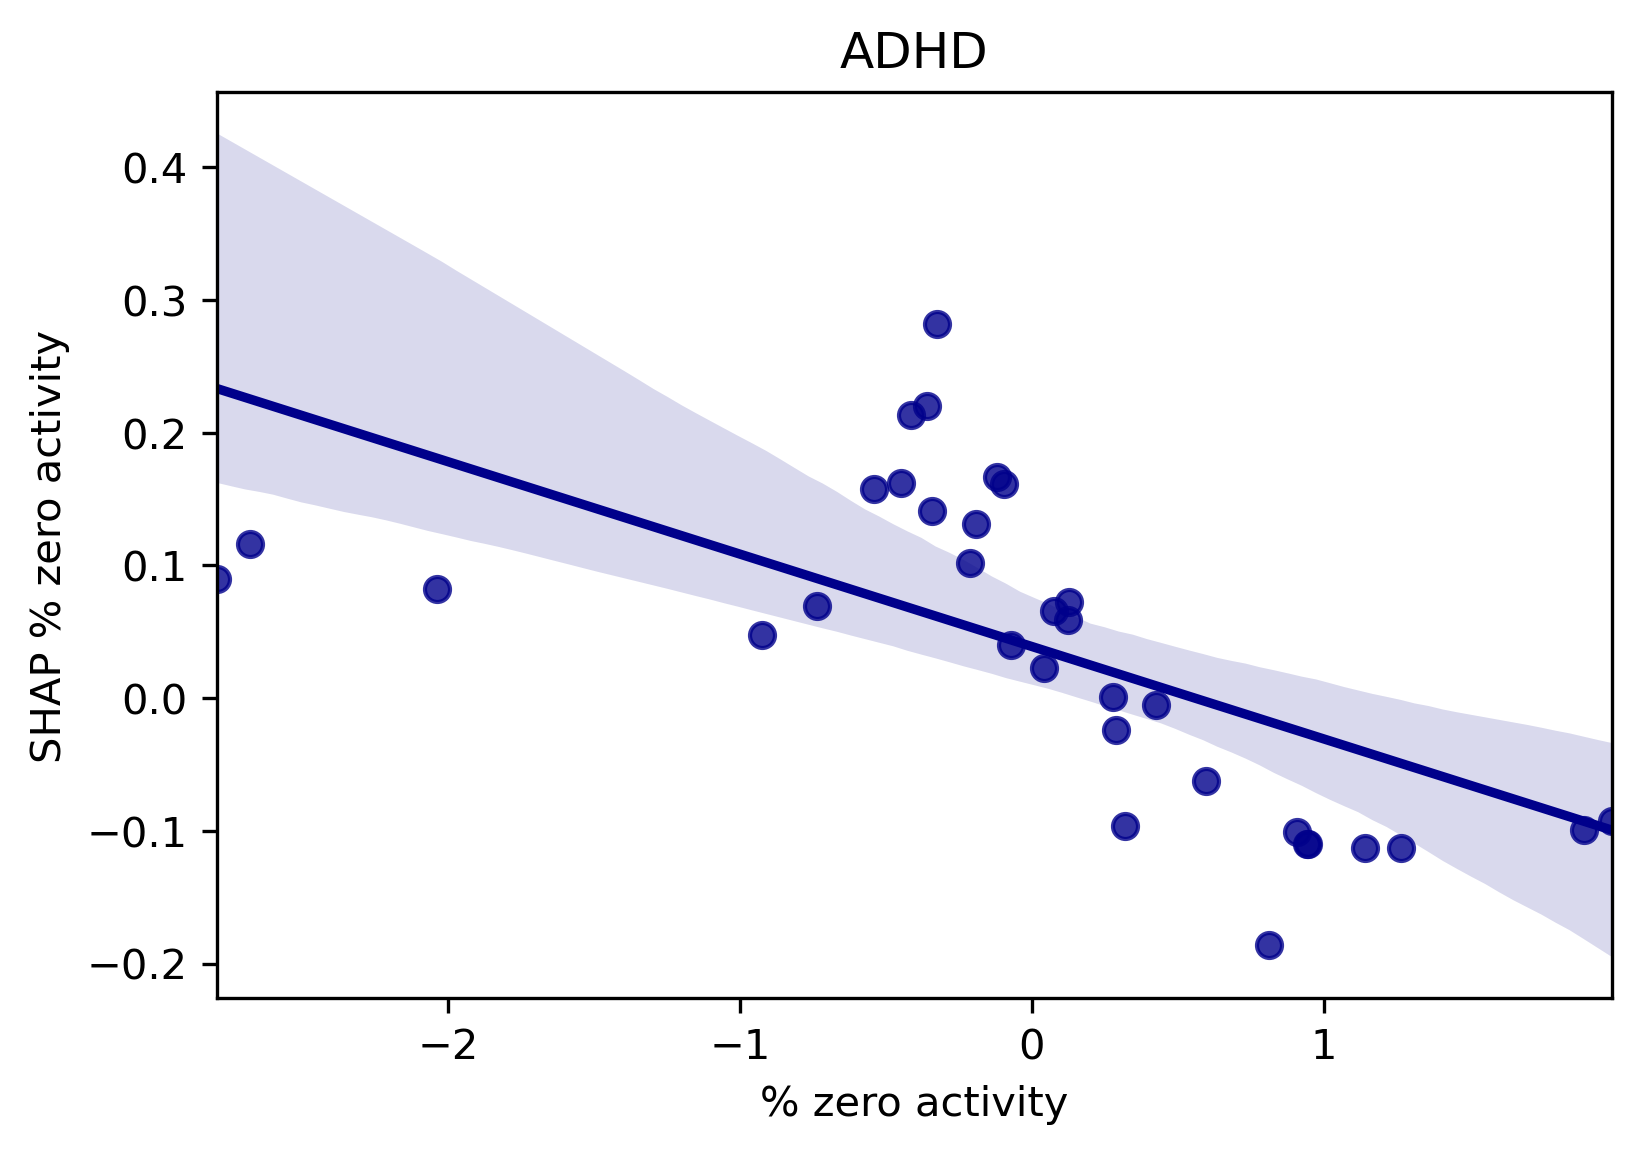

In [63]:
ax = sns.regplot(
    x=shap_x_test["perc_zero_act_test"],
    y=shap_x_test["perc_zero_act_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="% zero activity", ylabel="SHAP % zero activity")
plt.title("ADHD")

#### SHAP - Variance, ADHD¶

Text(0.5, 1.0, 'ADHD')

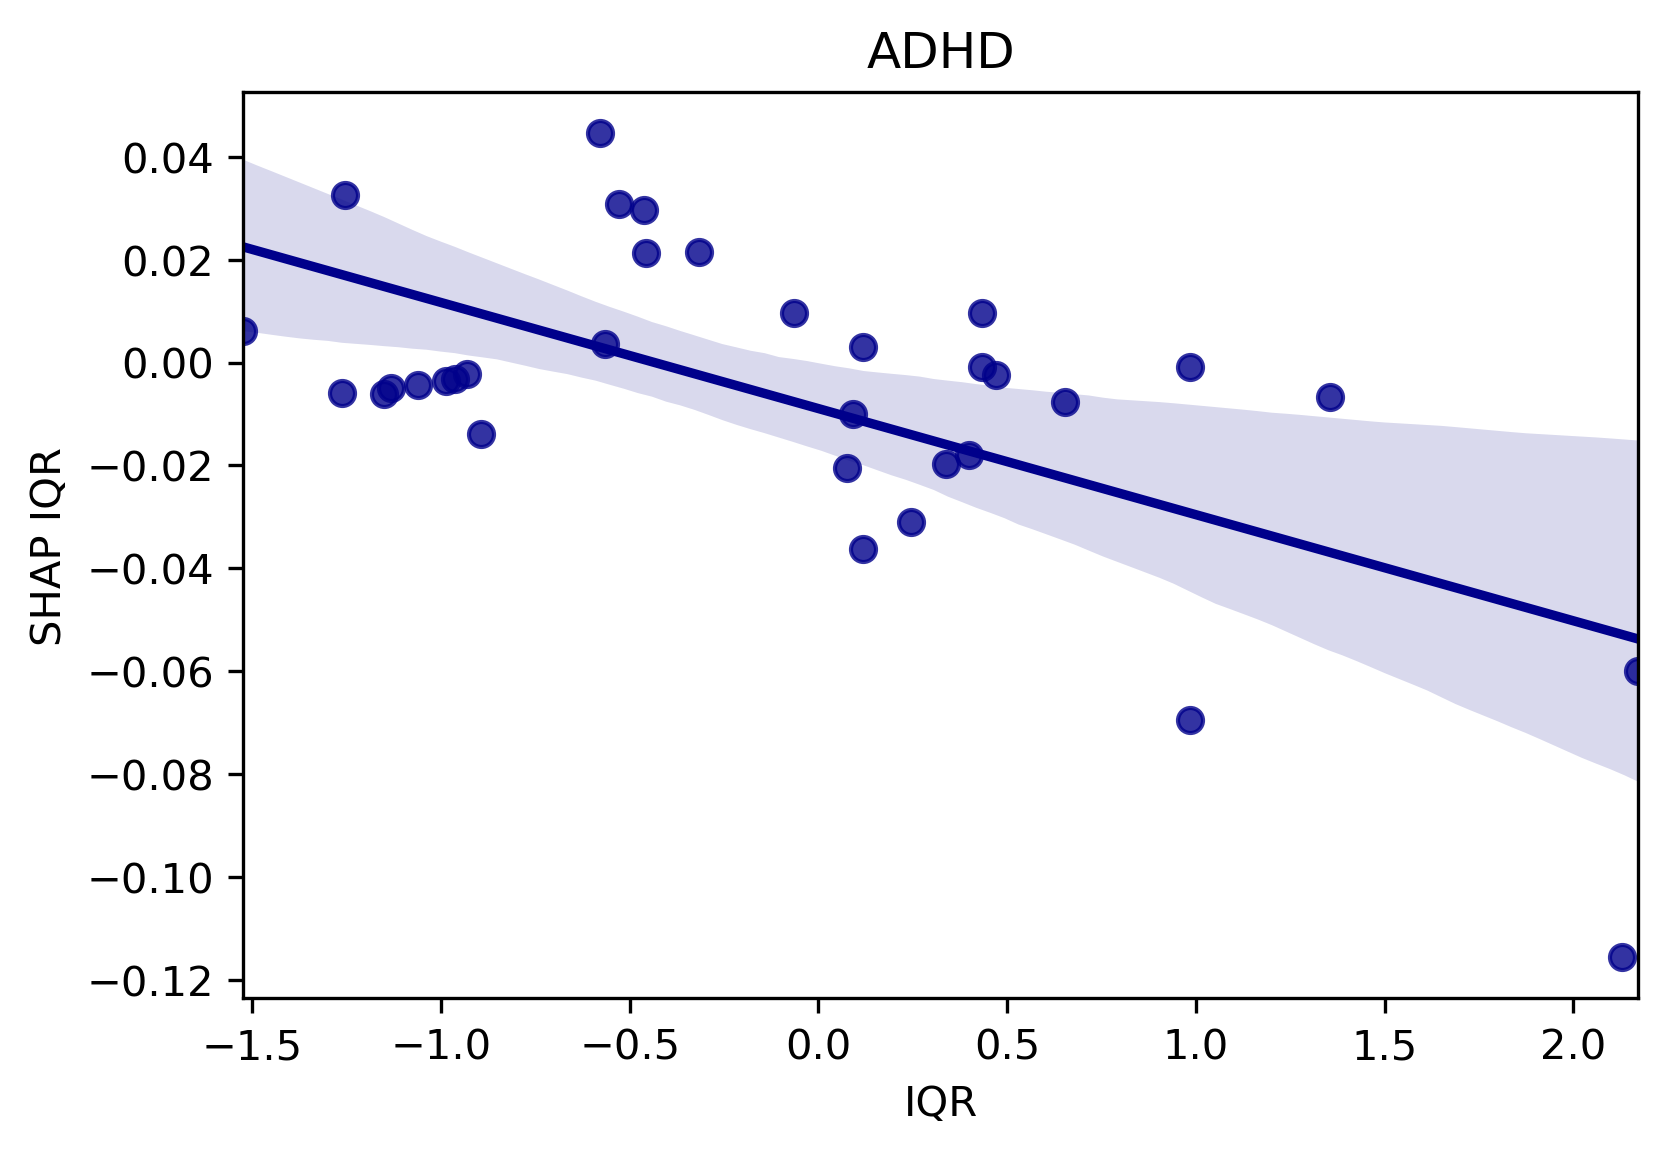

In [64]:
ax = sns.regplot(
    x=shap_x_test["IQR_test"],
    y=shap_x_test["IQR_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="IQR", ylabel="SHAP IQR")
plt.title("ADHD")

#### SHAP - Coefficent of variation, ADHD

Text(0.5, 1.0, 'ADHD')

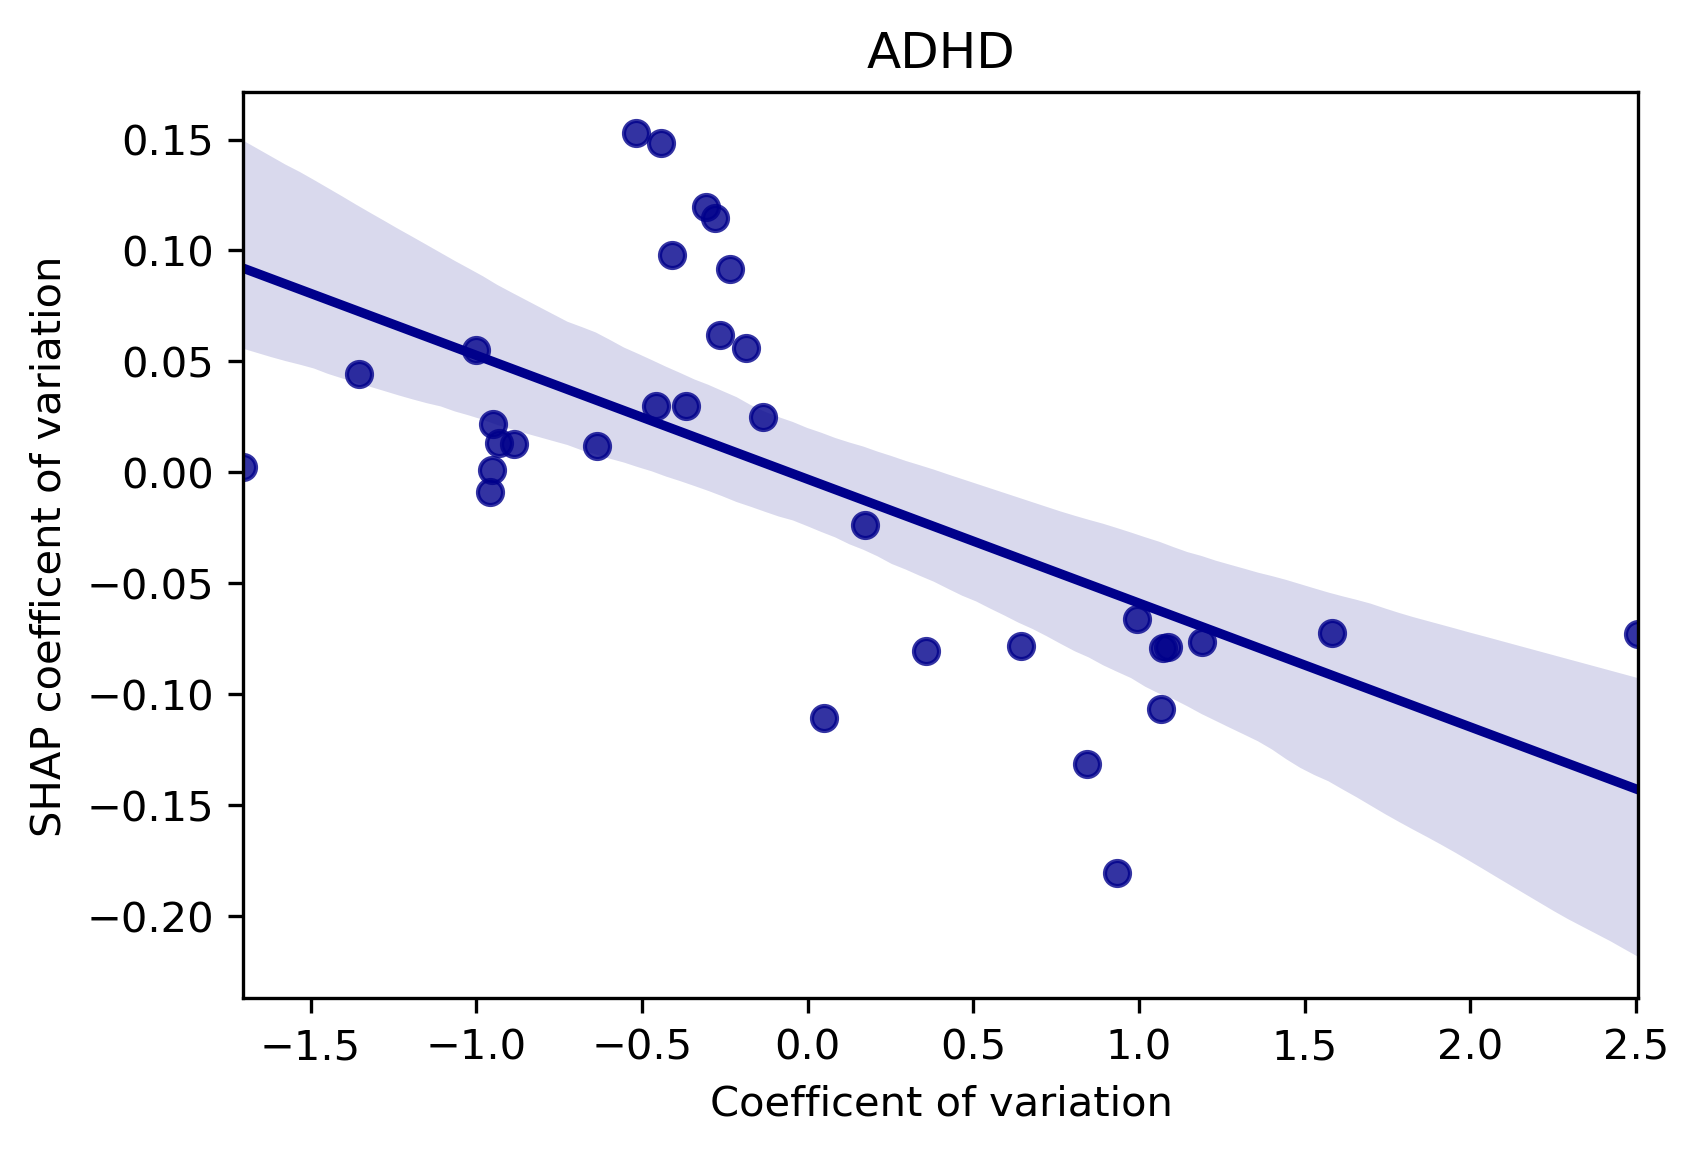

In [65]:
ax = sns.regplot(
    x=shap_x_test["cov_test"],
    y=shap_x_test["cov_shap"],
    data=shap_x_test,
    color="darkblue",
)
ax.set(xlabel="Coefficent of variation", ylabel="SHAP coefficent of variation")
plt.title("ADHD")